<a href="https://colab.research.google.com/github/gkuch22/ml-final/blob/main/final_model_experiment_prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [186]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [187]:
import torch # Main PyTorch Library
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import seaborn as sns

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)


Device available:  cpu


In [339]:
train_df = pd.read_csv('/content/drive/MyDrive/cs231n/assignments/final/datasets/train.csv')
stores_df = pd.read_csv('/content/drive/MyDrive/cs231n/assignments/final/datasets/stores.csv')
features_df = pd.read_csv('/content/drive/MyDrive/cs231n/assignments/final/datasets/features.csv')

In [340]:
train_df

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False


In [341]:
stores_df

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875
5,6,A,202505
6,7,B,70713
7,8,A,155078
8,9,B,125833
9,10,B,126512


In [342]:
features_df

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False


In [343]:
features_df = features_df.drop(columns=["IsHoliday"])

train_df['Date'] = pd.to_datetime(train_df['Date'])
features_df['Date'] = pd.to_datetime(features_df['Date'])

merged_df = pd.merge(train_df, features_df, on=['Store', 'Date'], how='left')
merged_df = pd.merge(merged_df, stores_df, on='Store', how='left')

merged_df = merged_df.sort_values(by=['Store', 'Dept', 'Date']).reset_index(drop=True)

# DATA ANALYSIS

In [ ]:
merged_df['Year'] = merged_df['Date'].dt.year
merged_df['Month'] = merged_df['Date'].dt.month
merged_df['Week'] = merged_df['Date'].dt.isocalendar().week.astype(int)

year_split = 2012
month_split = 6

train_df = merged_df[merged_df['Year'] < year_split]
valid_df = merged_df[(merged_df['Year'] == year_split) & (merged_df['Month'] < month_split)]
test_df = merged_df[(merged_df['Year'] == year_split) & (merged_df['Month'] >= month_split)]

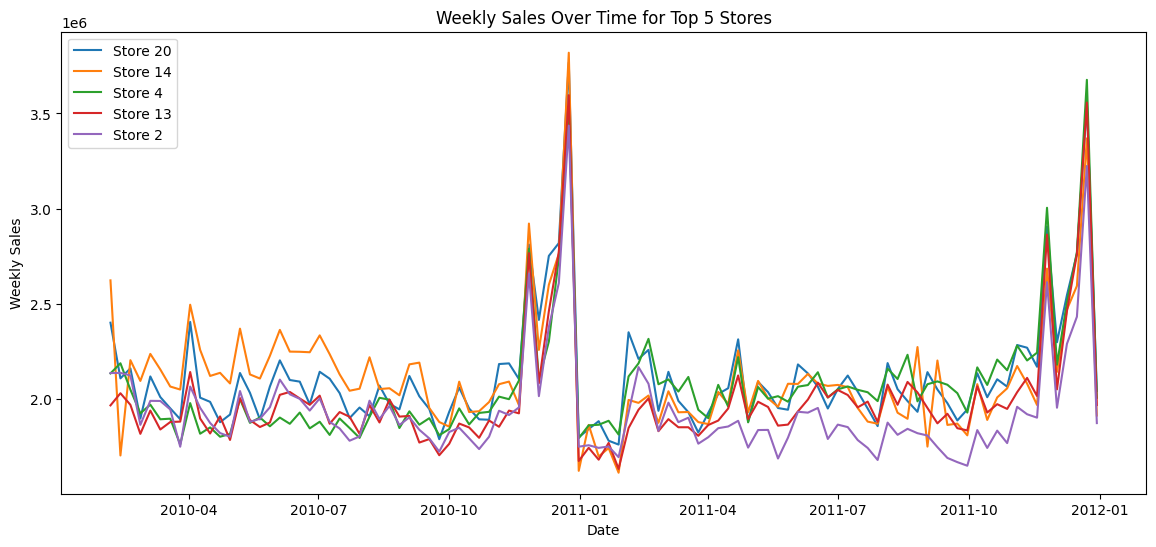

In [ ]:
top_stores = train_df.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False).head(5).index

plt.figure(figsize=(14, 6))
for store in top_stores:
    store_sales = train_df[train_df['Store'] == store].groupby('Date')['Weekly_Sales'].sum()
    plt.plot(store_sales.index, store_sales.values, label=f'Store {store}')
plt.title("Weekly Sales Over Time for Top 5 Stores")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.show()

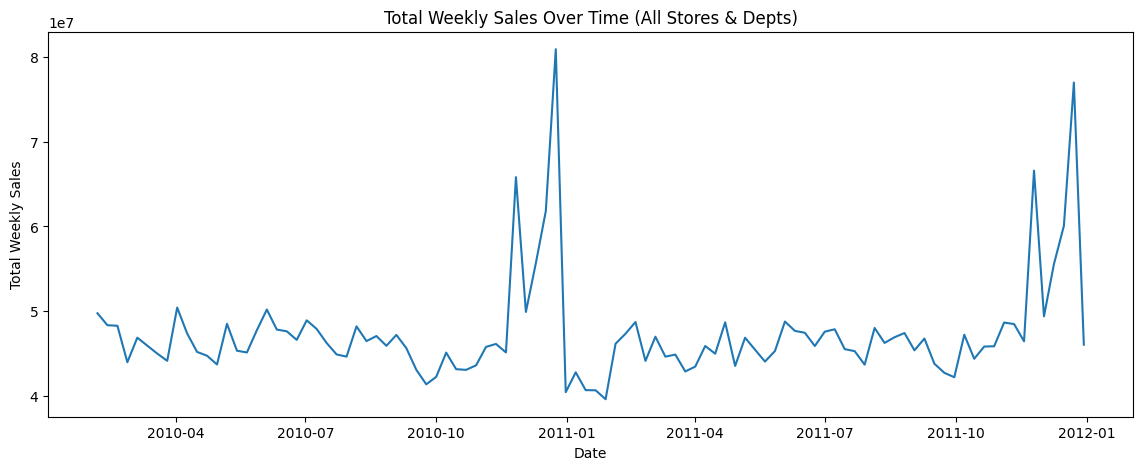

In [ ]:
weekly_sales = train_df.groupby('Date')['Weekly_Sales'].sum()

plt.figure(figsize=(14, 5))
plt.plot(weekly_sales.index, weekly_sales.values)
plt.title("Total Weekly Sales Over Time (All Stores & Depts)")
plt.xlabel("Date")
plt.ylabel("Total Weekly Sales")
plt.show()

/tmp/ipython-input-146-1725467886.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['IsHoliday'] = train_df['IsHoliday'].astype(bool)


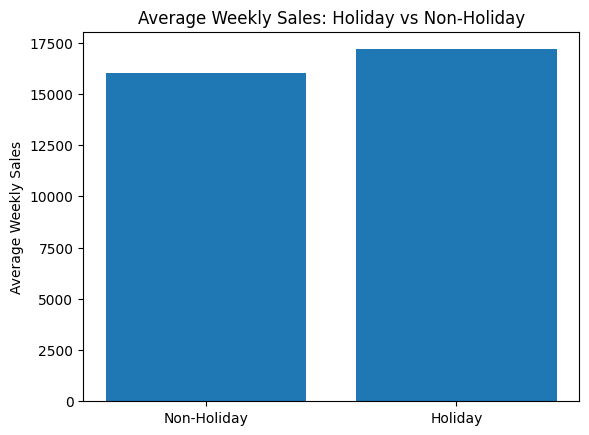

In [ ]:
train_df['IsHoliday'] = train_df['IsHoliday'].astype(bool)
holiday_sales = train_df.groupby('IsHoliday')['Weekly_Sales'].mean()

plt.bar(['Non-Holiday', 'Holiday'], holiday_sales.values)
plt.title("Average Weekly Sales: Holiday vs Non-Holiday")
plt.ylabel("Average Weekly Sales")
plt.show()

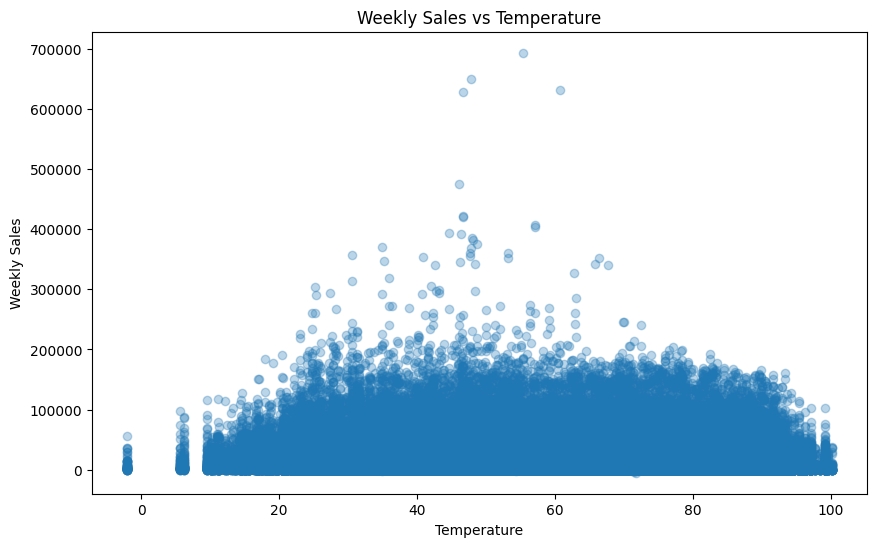

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(train_df['Temperature'], train_df['Weekly_Sales'], alpha=0.3)
plt.title("Weekly Sales vs Temperature")
plt.xlabel("Temperature")
plt.ylabel("Weekly Sales")
plt.show()


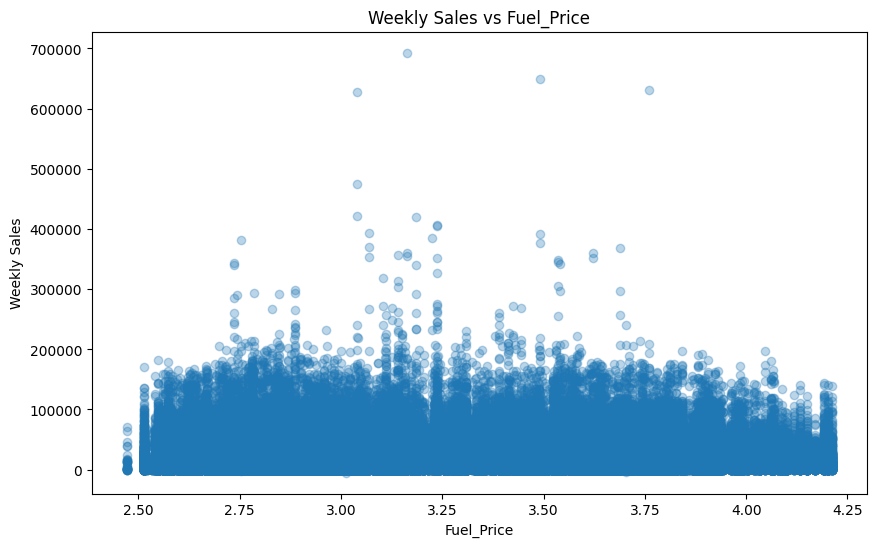

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(train_df['Fuel_Price'], train_df['Weekly_Sales'], alpha=0.3)
plt.title("Weekly Sales vs Fuel_Price")
plt.xlabel("Fuel_Price")
plt.ylabel("Weekly Sales")
plt.show()


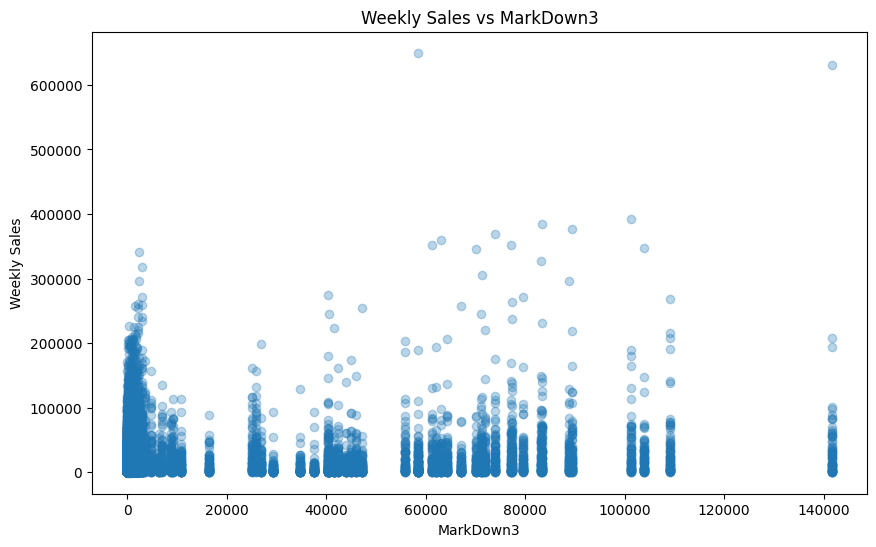

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(train_df['MarkDown3'], train_df['Weekly_Sales'], alpha=0.3)
plt.title("Weekly Sales vs MarkDown3")
plt.xlabel("MarkDown3")
plt.ylabel("Weekly Sales")
plt.show()


# MODEL TRAINING

In [242]:
def get_wmae(y_true, y_pred, weights):
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)
  weights = np.array(weights)
  return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

In [227]:
import logging
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

from prophet import Prophet

all_train_true = []
all_train_pred = []
all_train_weights = []

all_valid_true = []
all_valid_pred = []
all_valid_weights = []

store_dept_pairs = merged_df[['Store', 'Dept']].drop_duplicates().values

for store, dept in store_dept_pairs:
  print(f"{store} - {dept}")
  store_dept_pair = merged_df[(merged_df['Store'] == store) & (merged_df['Dept'] == dept)].copy()
  store_dept_pair = store_dept_pair.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})

  store_dept_pair['Year'] = store_dept_pair['ds'].dt.year
  store_dept_pair['Month'] = store_dept_pair['ds'].dt.month
  store_dept_pair['Week'] = store_dept_pair['ds'].dt.isocalendar().week.astype(int)

  year_split = 2012
  month_split = 6

  train_df = store_dept_pair[store_dept_pair['Year'] < year_split]
  valid_df = store_dept_pair[(store_dept_pair['Year'] == year_split) & (store_dept_pair['Month'] < month_split)]
  test_df = store_dept_pair[(store_dept_pair['Year'] == year_split) & (store_dept_pair['Month'] >= month_split)]

  if train_df.empty or valid_df.empty:
    continue

  if train_df['y'].notna().sum() < 2 or valid_df['y'].notna().sum() == 0:
    continue

  regressors = [
    'IsHoliday',
    'Temperature',
    'Fuel_Price',
    'CPI',
    'Unemployment',
  ]

  cps = 0.01
  sps = 5
  model = Prophet(
    changepoint_prior_scale=cps,
    seasonality_prior_scale=sps,
    seasonality_mode='multiplicative',
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
  )

  for reg in regressors:
    model.add_regressor(reg)

  model.fit(train_df[['ds', 'y'] + regressors])


  y_pred_train = model.predict(train_df[['ds'] + regressors])
  y_pred_valid = model.predict(valid_df[['ds'] + regressors])

  yhat_train = y_pred_train['yhat'].values
  yhat_valid = y_pred_valid['yhat'].values

  all_train_true.extend(train_df['y'].values)
  all_train_pred.extend(yhat_train)
  all_train_weights.extend(np.where(train_df['IsHoliday'], 5, 1))

  all_valid_true.extend(valid_df['y'].values)
  all_valid_pred.extend(yhat_valid)
  all_valid_weights.extend(np.where(valid_df['IsHoliday'], 5, 1))

train_wmae = get_wmae(all_train_true, all_train_pred, all_train_weights)
valid_wmae = get_wmae(all_valid_true, all_valid_pred, all_valid_weights)

print(f"train wmae: {train_wmae:.2f}")
print(f"valid wmae: {valid_wmae:.2f}")
print()


1 - 1
1 - 2
1 - 3
1 - 4
1 - 5
1 - 6
1 - 7
1 - 8
1 - 9
1 - 10
1 - 11
1 - 12
1 - 13


13:16:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


1 - 14
1 - 16
1 - 17
1 - 18
1 - 19
1 - 20
1 - 21
1 - 22
1 - 23
1 - 24
1 - 25
1 - 26


13:16:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


1 - 27
1 - 28
1 - 29
1 - 30
1 - 31
1 - 32
1 - 33
1 - 34
1 - 35
1 - 36
1 - 37
1 - 38
1 - 40
1 - 41
1 - 42
1 - 44
1 - 45
1 - 46
1 - 47
1 - 48
1 - 49
1 - 51
1 - 52
1 - 54


13:16:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


1 - 55
1 - 56
1 - 58
1 - 59
1 - 60
1 - 67


13:16:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


1 - 71
1 - 72
1 - 74
1 - 77
1 - 78
1 - 79
1 - 80
1 - 81
1 - 82
1 - 83
1 - 85
1 - 87
1 - 90
1 - 91
1 - 92
1 - 93
1 - 94
1 - 95
1 - 96
1 - 97
1 - 98
1 - 99
2 - 1
2 - 2
2 - 3
2 - 4
2 - 5
2 - 6
2 - 7
2 - 8
2 - 9
2 - 10
2 - 11
2 - 12
2 - 13
2 - 14
2 - 16
2 - 17
2 - 18
2 - 19
2 - 20
2 - 21
2 - 22
2 - 23
2 - 24
2 - 25
2 - 26
2 - 27
2 - 28
2 - 29
2 - 30
2 - 31
2 - 32
2 - 33
2 - 34
2 - 35
2 - 36
2 - 37
2 - 38
2 - 39
2 - 40
2 - 41
2 - 42
2 - 44
2 - 45
2 - 46
2 - 47
2 - 48
2 - 49
2 - 51
2 - 52
2 - 54
2 - 55
2 - 56
2 - 58
2 - 59
2 - 60
2 - 67
2 - 71
2 - 72
2 - 74
2 - 77
2 - 78
2 - 79
2 - 80
2 - 81
2 - 82
2 - 83
2 - 85
2 - 87
2 - 90
2 - 91
2 - 92
2 - 93
2 - 94
2 - 95
2 - 96
2 - 97
2 - 98
2 - 99
3 - 1
3 - 2
3 - 3
3 - 4
3 - 5
3 - 6
3 - 7
3 - 8
3 - 9
3 - 10
3 - 11


13:17:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


3 - 12
3 - 13
3 - 14
3 - 16


13:17:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


3 - 17
3 - 18
3 - 19
3 - 20
3 - 21
3 - 22
3 - 23
3 - 24
3 - 25
3 - 26
3 - 27
3 - 28
3 - 29
3 - 30
3 - 31
3 - 32


13:17:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


3 - 33
3 - 34
3 - 35
3 - 36
3 - 38
3 - 40
3 - 41
3 - 42
3 - 44
3 - 45
3 - 46
3 - 47
3 - 49
3 - 51
3 - 52
3 - 54
3 - 55
3 - 56
3 - 59
3 - 60
3 - 67
3 - 71
3 - 72
3 - 74
3 - 77
3 - 78
3 - 79
3 - 80
3 - 81
3 - 82
3 - 83
3 - 85
3 - 87
3 - 90
3 - 91
3 - 92
3 - 94
3 - 95
3 - 96
3 - 97
3 - 98
4 - 1
4 - 2
4 - 3
4 - 4
4 - 5
4 - 6
4 - 7
4 - 8
4 - 9
4 - 10
4 - 11
4 - 12


13:17:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


4 - 13
4 - 14


13:17:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


4 - 16
4 - 17
4 - 18
4 - 19
4 - 20
4 - 21
4 - 22
4 - 23
4 - 24
4 - 25
4 - 26
4 - 27
4 - 28
4 - 29
4 - 30
4 - 31
4 - 32
4 - 33
4 - 34
4 - 35
4 - 36
4 - 37
4 - 38
4 - 39
4 - 40
4 - 41
4 - 42
4 - 44
4 - 45
4 - 46
4 - 47
4 - 48
4 - 49
4 - 51
4 - 52
4 - 54
4 - 55
4 - 56
4 - 58
4 - 59
4 - 60
4 - 67
4 - 71
4 - 72
4 - 74
4 - 77
4 - 78
4 - 79
4 - 80
4 - 81
4 - 82
4 - 83
4 - 85
4 - 87
4 - 90
4 - 91
4 - 92
4 - 93
4 - 94
4 - 95
4 - 96
4 - 97
4 - 98
4 - 99
5 - 1
5 - 2
5 - 3
5 - 4
5 - 5
5 - 6
5 - 7
5 - 8
5 - 9
5 - 10
5 - 11
5 - 12
5 - 13
5 - 14
5 - 16
5 - 17
5 - 18
5 - 19
5 - 20
5 - 21
5 - 22
5 - 23
5 - 24
5 - 25
5 - 26
5 - 27
5 - 28
5 - 29
5 - 30
5 - 31
5 - 32
5 - 33
5 - 34
5 - 35
5 - 36
5 - 38
5 - 40
5 - 41
5 - 42
5 - 44
5 - 45
5 - 46
5 - 47
5 - 49
5 - 51
5 - 52
5 - 54
5 - 55
5 - 56
5 - 58
5 - 59
5 - 60
5 - 67
5 - 71
5 - 72
5 - 74
5 - 77
5 - 78
5 - 79
5 - 80
5 - 81
5 - 82
5 - 85
5 - 87
5 - 90
5 - 91


13:18:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


5 - 92
5 - 94
5 - 95
5 - 96
5 - 97
5 - 98
6 - 1
6 - 2
6 - 3
6 - 4
6 - 5
6 - 6
6 - 7
6 - 8
6 - 9
6 - 10
6 - 11
6 - 12
6 - 13
6 - 14


13:18:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


6 - 16
6 - 17
6 - 18
6 - 19
6 - 20
6 - 21
6 - 22
6 - 23
6 - 24
6 - 25
6 - 26
6 - 27
6 - 28
6 - 29
6 - 30
6 - 31
6 - 32
6 - 33
6 - 34
6 - 35
6 - 36
6 - 37
6 - 38
6 - 40
6 - 41
6 - 42
6 - 44
6 - 45
6 - 46
6 - 47
6 - 48
6 - 49
6 - 51
6 - 52
6 - 54
6 - 55
6 - 56
6 - 58
6 - 59
6 - 60
6 - 67
6 - 71
6 - 72
6 - 74
6 - 77
6 - 78
6 - 79
6 - 80
6 - 81
6 - 82
6 - 83
6 - 85
6 - 87
6 - 90
6 - 91
6 - 92
6 - 93
6 - 94
6 - 95
6 - 96
6 - 97
6 - 98
6 - 99
7 - 1
7 - 2
7 - 3
7 - 4
7 - 5
7 - 6
7 - 7
7 - 8
7 - 9
7 - 10
7 - 11


13:18:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


7 - 12
7 - 13
7 - 14
7 - 16
7 - 17
7 - 18
7 - 19
7 - 20
7 - 21
7 - 22
7 - 23


13:18:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


7 - 24
7 - 25
7 - 26
7 - 27
7 - 28
7 - 29


13:18:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


7 - 30
7 - 31


13:18:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


7 - 32


13:18:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


7 - 33
7 - 34
7 - 35


13:18:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


7 - 36
7 - 38
7 - 40


13:18:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


7 - 41
7 - 42
7 - 44
7 - 45
7 - 46
7 - 47
7 - 48
7 - 49
7 - 51
7 - 52
7 - 54
7 - 55
7 - 56
7 - 58
7 - 59
7 - 60
7 - 67
7 - 71
7 - 72
7 - 74
7 - 77
7 - 78
7 - 79
7 - 80
7 - 81
7 - 82
7 - 83
7 - 85
7 - 87


13:19:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


7 - 90
7 - 91
7 - 92
7 - 93
7 - 94
7 - 95
7 - 96


13:19:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


7 - 97
7 - 98
7 - 99
8 - 1
8 - 2
8 - 3
8 - 4
8 - 5
8 - 6
8 - 7
8 - 8
8 - 9
8 - 10
8 - 11
8 - 12
8 - 13
8 - 14


13:19:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


8 - 16
8 - 17
8 - 18
8 - 19
8 - 20
8 - 21
8 - 22
8 - 23
8 - 24
8 - 25
8 - 26
8 - 27
8 - 28
8 - 29
8 - 30
8 - 31
8 - 32
8 - 33
8 - 34
8 - 35
8 - 36
8 - 37
8 - 38
8 - 40
8 - 41
8 - 42
8 - 44
8 - 45
8 - 46
8 - 47
8 - 49
8 - 51
8 - 52
8 - 54
8 - 55
8 - 56
8 - 58
8 - 59
8 - 60
8 - 67
8 - 71
8 - 72
8 - 74
8 - 77
8 - 78
8 - 79
8 - 80
8 - 81
8 - 82
8 - 83
8 - 85
8 - 87
8 - 90
8 - 91
8 - 92
8 - 93
8 - 94
8 - 95
8 - 96
8 - 97
8 - 98
8 - 99
9 - 1
9 - 2
9 - 3
9 - 4
9 - 5
9 - 6
9 - 7
9 - 8
9 - 9
9 - 10
9 - 11
9 - 12
9 - 13
9 - 14


13:19:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


9 - 16
9 - 17
9 - 18
9 - 19
9 - 20
9 - 21
9 - 22
9 - 23
9 - 24
9 - 25
9 - 26
9 - 27
9 - 28
9 - 29
9 - 30
9 - 31
9 - 32
9 - 33
9 - 34
9 - 35
9 - 36
9 - 38
9 - 40
9 - 41
9 - 42
9 - 44
9 - 45
9 - 46
9 - 47
9 - 48
9 - 49
9 - 51
9 - 52
9 - 54
9 - 55
9 - 56
9 - 59
9 - 60
9 - 67
9 - 71
9 - 72
9 - 74
9 - 77
9 - 78
9 - 79
9 - 80
9 - 81
9 - 82
9 - 85
9 - 87
9 - 90
9 - 91
9 - 92
9 - 93
9 - 94
9 - 95
9 - 96
9 - 97
9 - 98
10 - 1
10 - 2
10 - 3
10 - 4
10 - 5
10 - 6
10 - 7
10 - 8
10 - 9
10 - 10
10 - 11
10 - 12
10 - 13
10 - 14


13:20:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


10 - 16
10 - 17
10 - 18
10 - 19
10 - 20
10 - 21
10 - 22
10 - 23
10 - 24
10 - 25
10 - 26
10 - 27
10 - 28
10 - 29
10 - 30
10 - 31
10 - 32
10 - 33
10 - 34
10 - 35


13:20:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


10 - 36
10 - 37
10 - 38
10 - 40
10 - 41
10 - 42
10 - 44
10 - 45
10 - 46
10 - 47


13:20:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


10 - 48
10 - 49
10 - 50
10 - 51
10 - 52
10 - 54
10 - 55
10 - 56
10 - 58
10 - 59
10 - 60
10 - 67
10 - 71
10 - 72
10 - 74
10 - 77
10 - 78
10 - 79
10 - 80
10 - 81
10 - 82
10 - 83
10 - 85
10 - 87
10 - 90
10 - 91
10 - 92
10 - 93
10 - 94
10 - 95
10 - 96
10 - 97
10 - 98
11 - 1
11 - 2
11 - 3
11 - 4
11 - 5
11 - 6
11 - 7
11 - 8
11 - 9
11 - 10
11 - 11
11 - 12
11 - 13
11 - 14


13:20:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


11 - 16
11 - 17
11 - 18
11 - 19
11 - 20
11 - 21
11 - 22
11 - 23
11 - 24
11 - 25
11 - 26
11 - 27
11 - 28
11 - 29
11 - 30
11 - 31
11 - 32
11 - 33
11 - 34
11 - 35
11 - 36
11 - 37
11 - 38
11 - 40
11 - 41
11 - 42
11 - 44
11 - 45
11 - 46
11 - 47
11 - 48
11 - 49
11 - 50
11 - 51
11 - 52
11 - 54
11 - 55
11 - 56
11 - 58
11 - 59
11 - 60
11 - 67
11 - 71
11 - 72
11 - 74
11 - 77
11 - 78
11 - 79
11 - 80
11 - 81
11 - 82
11 - 83
11 - 85
11 - 87
11 - 90
11 - 91
11 - 92
11 - 93
11 - 94
11 - 95
11 - 96
11 - 97
11 - 98
11 - 99
12 - 1
12 - 2
12 - 3
12 - 4
12 - 5
12 - 6
12 - 7
12 - 8
12 - 9
12 - 10
12 - 11
12 - 12
12 - 13
12 - 14


13:21:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


12 - 16
12 - 17
12 - 18
12 - 19
12 - 20
12 - 21
12 - 22
12 - 23
12 - 24
12 - 25
12 - 26
12 - 27
12 - 28
12 - 29
12 - 30
12 - 31
12 - 32
12 - 33
12 - 34
12 - 35
12 - 36
12 - 38
12 - 40
12 - 41
12 - 42
12 - 44
12 - 45
12 - 46
12 - 47
12 - 49
12 - 51
12 - 52
12 - 54
12 - 55
12 - 56
12 - 58
12 - 59
12 - 60
12 - 67
12 - 71
12 - 72
12 - 74
12 - 77
12 - 78
12 - 79
12 - 80
12 - 81
12 - 82
12 - 83
12 - 85
12 - 87
12 - 90
12 - 91
12 - 92
12 - 93
12 - 94
12 - 95
12 - 96
12 - 97
12 - 98
12 - 99
13 - 1
13 - 2
13 - 3
13 - 4
13 - 5
13 - 6
13 - 7
13 - 8
13 - 9
13 - 10
13 - 11
13 - 12
13 - 13
13 - 14


13:21:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


13 - 16
13 - 17
13 - 18


13:21:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


13 - 19
13 - 20
13 - 21
13 - 22
13 - 23
13 - 24
13 - 25
13 - 26
13 - 27
13 - 28
13 - 29
13 - 30
13 - 31
13 - 32
13 - 33
13 - 34
13 - 35
13 - 36
13 - 37
13 - 38
13 - 40
13 - 41
13 - 42
13 - 43
13 - 44
13 - 45
13 - 46
13 - 47
13 - 48
13 - 49
13 - 50
13 - 51
13 - 52
13 - 54
13 - 55
13 - 56
13 - 58
13 - 59
13 - 60
13 - 67
13 - 71
13 - 72
13 - 74
13 - 77
13 - 78
13 - 79
13 - 80
13 - 81
13 - 82
13 - 83
13 - 85
13 - 87
13 - 90
13 - 91
13 - 92
13 - 93
13 - 94
13 - 95
13 - 96
13 - 97
13 - 98
13 - 99
14 - 1
14 - 2
14 - 3
14 - 4
14 - 5
14 - 6
14 - 7
14 - 8
14 - 9
14 - 10
14 - 11
14 - 12
14 - 13
14 - 14
14 - 16
14 - 17
14 - 18
14 - 19
14 - 20
14 - 21
14 - 22
14 - 23
14 - 24
14 - 25
14 - 26
14 - 27
14 - 28
14 - 29
14 - 30
14 - 31
14 - 32
14 - 33
14 - 34
14 - 35
14 - 36
14 - 38
14 - 40
14 - 41
14 - 42
14 - 43
14 - 44
14 - 45
14 - 46
14 - 47
14 - 49
14 - 50
14 - 51
14 - 52
14 - 54
14 - 55
14 - 56
14 - 58
14 - 59
14 - 60
14 - 67


13:22:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


14 - 71
14 - 72
14 - 74
14 - 77
14 - 78
14 - 79
14 - 80
14 - 81
14 - 82
14 - 83
14 - 85
14 - 87
14 - 90
14 - 91
14 - 92
14 - 93
14 - 94
14 - 95
14 - 96
14 - 97
14 - 98
14 - 99
15 - 1
15 - 2
15 - 3
15 - 4
15 - 5
15 - 6
15 - 7
15 - 8


13:22:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


15 - 9
15 - 10
15 - 11


13:22:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


15 - 12
15 - 13
15 - 14
15 - 16
15 - 17
15 - 18
15 - 19
15 - 20
15 - 21
15 - 22


13:22:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


15 - 23
15 - 24
15 - 25
15 - 26
15 - 27
15 - 28
15 - 29
15 - 30
15 - 31
15 - 32
15 - 33
15 - 34
15 - 35
15 - 36
15 - 37
15 - 38
15 - 40


13:22:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


15 - 41
15 - 42
15 - 43
15 - 44
15 - 45
15 - 46
15 - 47


13:22:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


15 - 48
15 - 49


13:22:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


15 - 50
15 - 51
15 - 52
15 - 54
15 - 55
15 - 56
15 - 58
15 - 59
15 - 60
15 - 67
15 - 71
15 - 72
15 - 74
15 - 77
15 - 78
15 - 79
15 - 80
15 - 81
15 - 82


13:23:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


15 - 83
15 - 85
15 - 87
15 - 90
15 - 91
15 - 92
15 - 93
15 - 94
15 - 95
15 - 96
15 - 97
15 - 98
15 - 99
16 - 1
16 - 2
16 - 3
16 - 4
16 - 5
16 - 6
16 - 7
16 - 8
16 - 9
16 - 10
16 - 11
16 - 12
16 - 13
16 - 14
16 - 16
16 - 17
16 - 18
16 - 19
16 - 20


13:23:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


16 - 21
16 - 22
16 - 23
16 - 24
16 - 25
16 - 26


13:23:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


16 - 27
16 - 28
16 - 29
16 - 30
16 - 31
16 - 32
16 - 33
16 - 34


13:23:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


16 - 35
16 - 36
16 - 38
16 - 40
16 - 41
16 - 42
16 - 44
16 - 45
16 - 46
16 - 47
16 - 48
16 - 49
16 - 51
16 - 52
16 - 54
16 - 55
16 - 56
16 - 58
16 - 59
16 - 60


13:23:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


16 - 67
16 - 71
16 - 72
16 - 74
16 - 77
16 - 78
16 - 79
16 - 80
16 - 81
16 - 82
16 - 83


13:23:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


16 - 85
16 - 87
16 - 90


13:23:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


16 - 91
16 - 92
16 - 93
16 - 94
16 - 95
16 - 96
16 - 97
16 - 98
16 - 99
17 - 1
17 - 2
17 - 3
17 - 4
17 - 5
17 - 6
17 - 7
17 - 8
17 - 9
17 - 10
17 - 11
17 - 12
17 - 13
17 - 14


13:23:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


17 - 16
17 - 17
17 - 18
17 - 19
17 - 20
17 - 21
17 - 22
17 - 23
17 - 24
17 - 25
17 - 26
17 - 27
17 - 28
17 - 29
17 - 30
17 - 31
17 - 32
17 - 33
17 - 34
17 - 35
17 - 36
17 - 38
17 - 40
17 - 41


13:23:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


17 - 42
17 - 44
17 - 45
17 - 46
17 - 47
17 - 48
17 - 49
17 - 51
17 - 52
17 - 54
17 - 55
17 - 56
17 - 58


13:23:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


17 - 59
17 - 60
17 - 67
17 - 71
17 - 72
17 - 74
17 - 77
17 - 78
17 - 79
17 - 80


13:23:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


17 - 81
17 - 82
17 - 83
17 - 85
17 - 87
17 - 90
17 - 91
17 - 92
17 - 93
17 - 94
17 - 95
17 - 96


13:23:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


17 - 97
17 - 98
17 - 99
18 - 1
18 - 2
18 - 3
18 - 4
18 - 5
18 - 6
18 - 7
18 - 8
18 - 9
18 - 10
18 - 11
18 - 12
18 - 13
18 - 14
18 - 16
18 - 17
18 - 18
18 - 19
18 - 20
18 - 21
18 - 22
18 - 23
18 - 24
18 - 25
18 - 26
18 - 27
18 - 28
18 - 29
18 - 30
18 - 31
18 - 32
18 - 33
18 - 34
18 - 35
18 - 36
18 - 38
18 - 39
18 - 40
18 - 41
18 - 42
18 - 44
18 - 45
18 - 46
18 - 47
18 - 48
18 - 49
18 - 50
18 - 51
18 - 52
18 - 54
18 - 55
18 - 56
18 - 58
18 - 59
18 - 60
18 - 67
18 - 71
18 - 72
18 - 74
18 - 77
18 - 78
18 - 79
18 - 80
18 - 81
18 - 82
18 - 83
18 - 85
18 - 87
18 - 90
18 - 91
18 - 92
18 - 93
18 - 94
18 - 95
18 - 96
18 - 97
18 - 98
18 - 99
19 - 1
19 - 2
19 - 3
19 - 4
19 - 5
19 - 6
19 - 7
19 - 8


13:24:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


19 - 9
19 - 10
19 - 11
19 - 12
19 - 13
19 - 14
19 - 16
19 - 17
19 - 18
19 - 19
19 - 20
19 - 21
19 - 22
19 - 23
19 - 24
19 - 25
19 - 26
19 - 27
19 - 28
19 - 29
19 - 30
19 - 31
19 - 32
19 - 33
19 - 34
19 - 35
19 - 36
19 - 37
19 - 38
19 - 39
19 - 40
19 - 41


13:24:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


19 - 42
19 - 44
19 - 45
19 - 46
19 - 47
19 - 48
19 - 49
19 - 50
19 - 51
19 - 52
19 - 54
19 - 55
19 - 56
19 - 58
19 - 59
19 - 60
19 - 67
19 - 71
19 - 72
19 - 74
19 - 77
19 - 78
19 - 79
19 - 80
19 - 81
19 - 82
19 - 83
19 - 85
19 - 87
19 - 90
19 - 91
19 - 92
19 - 93
19 - 94
19 - 95
19 - 96
19 - 97
19 - 98
19 - 99
20 - 1
20 - 2
20 - 3
20 - 4
20 - 5
20 - 6
20 - 7
20 - 8
20 - 9
20 - 10
20 - 11
20 - 12


13:24:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


20 - 13
20 - 14
20 - 16
20 - 17
20 - 18
20 - 19
20 - 20
20 - 21
20 - 22
20 - 23
20 - 24
20 - 25
20 - 26
20 - 27
20 - 28
20 - 29
20 - 30
20 - 31
20 - 32
20 - 33
20 - 34
20 - 35
20 - 36
20 - 37
20 - 38
20 - 40
20 - 41
20 - 42
20 - 44
20 - 45
20 - 46
20 - 47
20 - 48
20 - 49
20 - 50
20 - 51
20 - 52
20 - 54
20 - 55
20 - 56
20 - 58
20 - 59
20 - 60
20 - 67
20 - 71
20 - 72
20 - 74
20 - 77
20 - 78
20 - 79
20 - 80
20 - 81
20 - 82
20 - 83
20 - 85
20 - 87
20 - 90
20 - 91
20 - 92
20 - 93
20 - 94
20 - 95
20 - 96
20 - 97
20 - 98
20 - 99
21 - 1
21 - 2
21 - 3
21 - 4
21 - 5
21 - 6
21 - 7
21 - 8
21 - 9
21 - 10


13:25:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


21 - 11
21 - 12


21 - 13
21 - 14


13:25:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


21 - 16
21 - 17
21 - 18
21 - 19
21 - 20
21 - 21
21 - 22
21 - 23
21 - 24
21 - 25
21 - 26
21 - 27
21 - 28
21 - 29
21 - 30
21 - 31
21 - 32
21 - 33
21 - 34
21 - 35
21 - 36
21 - 38
21 - 40
21 - 41
21 - 42
21 - 44
21 - 45
21 - 46
21 - 47
21 - 48
21 - 49
21 - 50
21 - 51
21 - 52
21 - 54
21 - 55


13:25:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


21 - 56
21 - 58
21 - 59
21 - 60
21 - 67
21 - 71
21 - 72
21 - 74
21 - 77
21 - 78
21 - 79
21 - 80
21 - 81
21 - 82
21 - 83
21 - 85
21 - 87
21 - 90
21 - 91
21 - 92
21 - 93
21 - 94
21 - 95
21 - 96
21 - 97
21 - 98
21 - 99
22 - 1
22 - 2
22 - 3
22 - 4
22 - 5
22 - 6
22 - 7
22 - 8
22 - 9
22 - 10
22 - 11
22 - 12
22 - 13
22 - 14
22 - 16
22 - 17
22 - 18
22 - 19
22 - 20
22 - 21
22 - 22
22 - 23
22 - 24
22 - 25
22 - 26
22 - 27
22 - 28
22 - 29
22 - 30
22 - 31
22 - 32
22 - 33
22 - 34
22 - 35
22 - 36
22 - 38
22 - 40
22 - 41
22 - 42
22 - 44
22 - 45
22 - 46
22 - 47
22 - 48
22 - 49
22 - 51
22 - 52
22 - 54
22 - 55
22 - 56
22 - 58
22 - 59
22 - 60
22 - 67
22 - 71
22 - 72
22 - 74
22 - 77
22 - 78
22 - 79
22 - 80
22 - 81
22 - 82
22 - 83
22 - 85
22 - 87
22 - 90
22 - 91
22 - 92
22 - 93
22 - 94
22 - 95
22 - 96
22 - 97
22 - 98
22 - 99
23 - 1
23 - 2
23 - 3
23 - 4
23 - 5
23 - 6
23 - 7
23 - 8


13:26:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


23 - 9
23 - 10
23 - 11
23 - 12
23 - 13
23 - 14
23 - 16
23 - 17
23 - 18
23 - 19
23 - 20
23 - 21
23 - 22
23 - 23
23 - 24
23 - 25
23 - 26
23 - 27
23 - 28
23 - 29
23 - 30
23 - 31
23 - 32
23 - 33
23 - 34


13:26:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


23 - 35
23 - 36
23 - 38


13:26:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


23 - 40
23 - 41


13:26:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


23 - 42
23 - 44
23 - 45
23 - 46
23 - 47
23 - 48
23 - 49
23 - 50
23 - 51
23 - 52
23 - 54
23 - 55
23 - 56
23 - 58
23 - 59
23 - 60
23 - 67
23 - 71
23 - 72
23 - 74
23 - 77
23 - 78
23 - 79
23 - 80
23 - 81
23 - 82
23 - 83
23 - 85
23 - 87
23 - 90
23 - 91
23 - 92
23 - 93
23 - 94
23 - 95
23 - 96
23 - 97
23 - 98
23 - 99
24 - 1
24 - 2
24 - 3
24 - 4
24 - 5
24 - 6
24 - 7
24 - 8
24 - 9
24 - 10
24 - 11


13:26:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


24 - 12
24 - 13
24 - 14
24 - 16
24 - 17
24 - 18
24 - 19
24 - 20
24 - 21
24 - 22
24 - 23
24 - 24
24 - 25
24 - 26
24 - 27
24 - 28
24 - 29
24 - 30
24 - 31
24 - 32
24 - 33
24 - 34
24 - 35
24 - 36
24 - 37
24 - 38
24 - 40
24 - 41
24 - 42
24 - 44
24 - 45
24 - 46
24 - 47
24 - 49
24 - 50
24 - 51
24 - 52
24 - 54
24 - 55
24 - 56
24 - 58
24 - 59
24 - 60
24 - 67
24 - 71
24 - 72
24 - 74
24 - 77
24 - 78
24 - 79
24 - 80
24 - 81
24 - 82
24 - 83
24 - 85
24 - 87
24 - 90
24 - 91
24 - 92
24 - 93
24 - 94
24 - 95
24 - 96
24 - 97
24 - 98
24 - 99
25 - 1
25 - 2
25 - 3
25 - 4
25 - 5
25 - 6
25 - 7
25 - 8
25 - 9
25 - 10
25 - 11


13:27:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


25 - 12
25 - 13
25 - 14
25 - 16
25 - 17
25 - 18
25 - 19
25 - 20
25 - 21
25 - 22
25 - 23
25 - 24
25 - 25
25 - 26
25 - 27
25 - 28
25 - 29
25 - 30
25 - 31
25 - 32
25 - 33
25 - 34
25 - 35


13:27:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


25 - 36
25 - 37
25 - 38
25 - 40
25 - 41
25 - 42
25 - 44
25 - 45
25 - 46
25 - 47
25 - 48
25 - 49
25 - 50
25 - 51
25 - 52
25 - 54
25 - 55
25 - 56
25 - 58


13:27:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


25 - 59
25 - 60
25 - 67
25 - 71
25 - 72
25 - 74
25 - 77
25 - 78
25 - 79
25 - 80
25 - 81
25 - 82


13:27:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


25 - 83
25 - 85
25 - 87
25 - 90
25 - 91
25 - 92
25 - 93
25 - 94
25 - 95
25 - 96
25 - 97
25 - 98
26 - 1
26 - 2
26 - 3
26 - 4
26 - 5
26 - 6
26 - 7
26 - 8
26 - 9
26 - 10
26 - 11


13:27:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


26 - 12
26 - 13
26 - 14
26 - 16
26 - 17
26 - 18
26 - 19
26 - 20
26 - 21
26 - 22
26 - 23
26 - 24
26 - 25
26 - 26
26 - 27
26 - 28
26 - 29
26 - 30
26 - 31
26 - 32
26 - 33
26 - 34
26 - 35
26 - 36
26 - 38
26 - 40
26 - 41
26 - 42
26 - 44
26 - 45
26 - 46
26 - 47
26 - 48
26 - 49
26 - 50
26 - 51
26 - 52
26 - 54


13:27:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


26 - 55
26 - 56
26 - 59
26 - 60
26 - 67
26 - 71
26 - 72
26 - 74
26 - 77
26 - 78
26 - 79
26 - 80
26 - 81
26 - 82
26 - 83
26 - 85
26 - 87
26 - 90
26 - 91
26 - 92
26 - 93
26 - 94
26 - 95
26 - 96
26 - 97
26 - 98
26 - 99
27 - 1
27 - 2
27 - 3
27 - 4
27 - 5
27 - 6
27 - 7
27 - 8
27 - 9
27 - 10


13:28:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


27 - 11
27 - 12
27 - 13
27 - 14
27 - 16
27 - 17
27 - 18
27 - 19
27 - 20
27 - 21
27 - 22
27 - 23
27 - 24
27 - 25
27 - 26
27 - 27
27 - 28
27 - 29
27 - 30
27 - 31
27 - 32
27 - 33
27 - 34
27 - 35
27 - 36
27 - 37
27 - 38
27 - 39
27 - 40
27 - 41
27 - 42
27 - 44
27 - 45
27 - 46
27 - 47
27 - 49
27 - 50
27 - 51
27 - 52
27 - 54
27 - 55
27 - 56
27 - 58
27 - 59
27 - 60
27 - 67
27 - 71
27 - 72
27 - 74
27 - 77
27 - 78
27 - 79
27 - 80
27 - 81
27 - 82
27 - 83
27 - 85
27 - 87
27 - 90
27 - 91
27 - 92
27 - 93
27 - 94
27 - 95
27 - 96
27 - 97
27 - 98
27 - 99
28 - 1
28 - 2
28 - 3
28 - 4
28 - 5
28 - 6
28 - 7
28 - 8
28 - 9
28 - 10
28 - 11
28 - 12
28 - 13
28 - 14
28 - 16
28 - 17
28 - 18
28 - 19
28 - 20
28 - 21
28 - 22
28 - 23
28 - 24
28 - 25
28 - 26


13:28:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


28 - 27
28 - 28
28 - 29
28 - 30
28 - 31
28 - 32
28 - 33
28 - 34
28 - 35
28 - 36
28 - 37
28 - 38
28 - 40
28 - 41
28 - 42
28 - 43
28 - 44
28 - 45
28 - 46
28 - 47
28 - 49
28 - 51
28 - 52
28 - 54
28 - 55
28 - 56
28 - 58
28 - 59
28 - 60
28 - 67
28 - 71
28 - 72
28 - 74
28 - 77
28 - 78
28 - 79
28 - 80
28 - 81
28 - 82
28 - 83
28 - 85
28 - 87
28 - 90
28 - 91
28 - 92
28 - 93
28 - 94
28 - 95
28 - 96
28 - 97
28 - 98
28 - 99
29 - 1
29 - 2
29 - 3
29 - 4
29 - 5
29 - 6
29 - 7
29 - 8
29 - 9
29 - 10
29 - 11
29 - 12
29 - 13
29 - 14
29 - 16
29 - 17
29 - 18
29 - 19
29 - 20
29 - 21
29 - 22
29 - 23
29 - 24
29 - 25
29 - 26
29 - 27
29 - 28
29 - 29
29 - 30
29 - 31
29 - 32
29 - 33
29 - 34
29 - 35
29 - 36
29 - 38
29 - 40
29 - 41
29 - 42
29 - 43
29 - 44
29 - 45
29 - 46
29 - 47
29 - 48
29 - 49
29 - 51
29 - 52
29 - 54
29 - 55
29 - 56
29 - 58
29 - 59
29 - 60


13:29:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


29 - 67
29 - 71
29 - 72
29 - 74
29 - 77
29 - 78
29 - 79
29 - 80
29 - 81
29 - 82
29 - 83
29 - 85
29 - 87
29 - 90
29 - 91
29 - 92
29 - 93
29 - 94
29 - 95
29 - 96
29 - 97
29 - 98
29 - 99
30 - 1
30 - 2
30 - 3
30 - 4
30 - 5
30 - 6
30 - 7
30 - 8
30 - 9


13:29:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


30 - 10
30 - 11
30 - 12
30 - 13
30 - 14
30 - 16
30 - 17
30 - 18
30 - 19
30 - 20
30 - 21
30 - 22
30 - 23
30 - 24
30 - 25
30 - 26
30 - 27
30 - 28
30 - 29
30 - 31
30 - 32
30 - 33
30 - 34
30 - 38
30 - 40
30 - 41
30 - 42
30 - 44
30 - 46
30 - 49
30 - 52
30 - 55
30 - 56


13:29:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


30 - 59
30 - 60
30 - 67
30 - 72
30 - 74
30 - 79
30 - 80
30 - 81
30 - 82
30 - 83
30 - 85
30 - 87
30 - 90
30 - 91
30 - 92
30 - 93
30 - 94
30 - 95
30 - 96
30 - 97
30 - 98
30 - 99
31 - 1
31 - 2
31 - 3
31 - 4
31 - 5
31 - 6
31 - 7
31 - 8
31 - 9
31 - 10
31 - 11
31 - 12
31 - 13
31 - 14
31 - 16
31 - 17
31 - 18
31 - 19
31 - 20
31 - 21
31 - 22
31 - 23
31 - 24
31 - 25
31 - 26
31 - 27
31 - 28
31 - 29
31 - 30
31 - 31
31 - 32
31 - 33
31 - 34
31 - 35
31 - 36
31 - 37
31 - 38
31 - 40
31 - 41
31 - 42
31 - 44
31 - 45
31 - 46
31 - 47
31 - 49
31 - 51
31 - 52
31 - 54
31 - 55
31 - 56
31 - 58
31 - 59
31 - 60
31 - 67
31 - 71
31 - 72
31 - 74
31 - 77
31 - 78
31 - 79
31 - 80
31 - 81
31 - 82
31 - 83
31 - 85
31 - 87
31 - 90
31 - 91
31 - 92
31 - 93
31 - 94
31 - 95
31 - 96
31 - 97
31 - 98
31 - 99
32 - 1
32 - 2
32 - 3
32 - 4
32 - 5
32 - 6
32 - 7
32 - 8
32 - 9
32 - 10
32 - 11
32 - 12
32 - 13


13:30:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


32 - 14
32 - 16


ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


32 - 17
32 - 18
32 - 19
32 - 20
32 - 21
32 - 22
32 - 23
32 - 24


13:30:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


32 - 25
32 - 26
32 - 27
32 - 28
32 - 29
32 - 30
32 - 31
32 - 32
32 - 33
32 - 34
32 - 35
32 - 36
32 - 37
32 - 38
32 - 40
32 - 41
32 - 42
32 - 44
32 - 45
32 - 46
32 - 47
32 - 48


13:30:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


32 - 49


13:30:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


32 - 51
32 - 52
32 - 54
32 - 55
32 - 56
32 - 58
32 - 59
32 - 60
32 - 67
32 - 71
32 - 72
32 - 74
32 - 77
32 - 78
32 - 79
32 - 80
32 - 81
32 - 82
32 - 83
32 - 85
32 - 87
32 - 90
32 - 91
32 - 92
32 - 93
32 - 94
32 - 95
32 - 96
32 - 97
32 - 98
32 - 99
33 - 1
33 - 2
33 - 3
33 - 4
33 - 5
33 - 6
33 - 7
33 - 8
33 - 9


13:30:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


33 - 10
33 - 11
33 - 12
33 - 13
33 - 14
33 - 16
33 - 17
33 - 18
33 - 20
33 - 21
33 - 22
33 - 23
33 - 24
33 - 25
33 - 26
33 - 27
33 - 31
33 - 32
33 - 33
33 - 34
33 - 35
33 - 36
33 - 38
33 - 40
33 - 41
33 - 42
33 - 44
33 - 46
33 - 49
33 - 52
33 - 55
33 - 56
33 - 59
33 - 60
33 - 67
33 - 71
33 - 72
33 - 74
33 - 79
33 - 80
33 - 81
33 - 82
33 - 83
33 - 87
33 - 90
33 - 91
33 - 92
33 - 93
33 - 94
33 - 95
33 - 96
33 - 97
33 - 98
33 - 99
34 - 1
34 - 2
34 - 3
34 - 4
34 - 5
34 - 6
34 - 7
34 - 8
34 - 9
34 - 10
34 - 11
34 - 12
34 - 13
34 - 14
34 - 16


13:31:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


34 - 17
34 - 18
34 - 19
34 - 20
34 - 21
34 - 22
34 - 23
34 - 24
34 - 25
34 - 26
34 - 27
34 - 28
34 - 29
34 - 30
34 - 31
34 - 32
34 - 33
34 - 34
34 - 35
34 - 36
34 - 37
34 - 38
34 - 40
34 - 41
34 - 42
34 - 44
34 - 45
34 - 46
34 - 47
34 - 48
34 - 49
34 - 51
34 - 52
34 - 54
34 - 55
34 - 56
34 - 58
34 - 59
34 - 60
34 - 65
34 - 67
34 - 71
34 - 72
34 - 74
34 - 77
34 - 78
34 - 79
34 - 80
34 - 81
34 - 82
34 - 83
34 - 85
34 - 87
34 - 90
34 - 91
34 - 92
34 - 93
34 - 94
34 - 95
34 - 96
34 - 97
34 - 98
34 - 99
35 - 1
35 - 2
35 - 3
35 - 4
35 - 5
35 - 6
35 - 7
35 - 8
35 - 9
35 - 10
35 - 11
35 - 12
35 - 13
35 - 14
35 - 16
35 - 17
35 - 18
35 - 19
35 - 20
35 - 21
35 - 22
35 - 23
35 - 24
35 - 25
35 - 26
35 - 27
35 - 28
35 - 29
35 - 30
35 - 31
35 - 32
35 - 33
35 - 34
35 - 35
35 - 36
35 - 38
35 - 40
35 - 41
35 - 42
35 - 44
35 - 45
35 - 46
35 - 47
35 - 49
35 - 51
35 - 52
35 - 54
35 - 55
35 - 56
35 - 58
35 - 59
35 - 60
35 - 67


13:32:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


35 - 71
35 - 72
35 - 74
35 - 77
35 - 78
35 - 79
35 - 80
35 - 81
35 - 82
35 - 83
35 - 85
35 - 87
35 - 90
35 - 91
35 - 92
35 - 93
35 - 94
35 - 95
35 - 96
35 - 97
35 - 98
36 - 1
36 - 2
36 - 3
36 - 4
36 - 5
36 - 6
36 - 7
36 - 8
36 - 9
36 - 10
36 - 11
36 - 12
36 - 13
36 - 14
36 - 16
36 - 17
36 - 18
36 - 20
36 - 21
36 - 22
36 - 23
36 - 24
36 - 25
36 - 26
36 - 29
36 - 31
36 - 32
36 - 33
36 - 34
36 - 36
36 - 38
36 - 40
36 - 41
36 - 42
36 - 44
36 - 46
36 - 49
36 - 52
36 - 55
36 - 56
36 - 59
36 - 60
36 - 67
36 - 71
36 - 72
36 - 74
36 - 79
36 - 80
36 - 81
36 - 82
36 - 83
36 - 85
36 - 87
36 - 90
36 - 91
36 - 92
36 - 93
36 - 94
36 - 95
36 - 96
36 - 97
36 - 98
36 - 99
37 - 1
37 - 2
37 - 3
37 - 4
37 - 5
37 - 6
37 - 7
37 - 8
37 - 9
37 - 10
37 - 11
37 - 12
37 - 13
37 - 14
37 - 16
37 - 17
37 - 18
37 - 20
37 - 21
37 - 22
37 - 23
37 - 24
37 - 25
37 - 26
37 - 27
37 - 28
37 - 31
37 - 32
37 - 33
37 - 38
37 - 40


13:33:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


37 - 41
37 - 42
37 - 44
37 - 46
37 - 49
37 - 52
37 - 55
37 - 56


13:33:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


37 - 59
37 - 60
37 - 67
37 - 71
37 - 72
37 - 74
37 - 79
37 - 80
37 - 81
37 - 82
37 - 83
37 - 85


13:33:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


37 - 87
37 - 90
37 - 91
37 - 92
37 - 93
37 - 94
37 - 95
37 - 96
37 - 97
37 - 98
37 - 99
38 - 1
38 - 2
38 - 3
38 - 4
38 - 5
38 - 6
38 - 7
38 - 8
38 - 9
38 - 10
38 - 11
38 - 12
38 - 13
38 - 14
38 - 16
38 - 17
38 - 18
38 - 20
38 - 21
38 - 22
38 - 23
38 - 24
38 - 25
38 - 26
38 - 27
38 - 28
38 - 29
38 - 31
38 - 32
38 - 33
38 - 34
38 - 35
38 - 38
38 - 40
38 - 42
38 - 44
38 - 46
38 - 49
38 - 52
38 - 55
38 - 56


13:34:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


38 - 59
38 - 60
38 - 67
38 - 72
38 - 74
38 - 79
38 - 80
38 - 81
38 - 82
38 - 83
38 - 85
38 - 87
38 - 90
38 - 91
38 - 92
38 - 93
38 - 94
38 - 95
38 - 96
38 - 97
38 - 98
38 - 99
39 - 1
39 - 2
39 - 3
39 - 4
39 - 5
39 - 6
39 - 7
39 - 8
39 - 9
39 - 10
39 - 11
39 - 12
39 - 13
39 - 14


13:34:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


39 - 16
39 - 17
39 - 18
39 - 19
39 - 20
39 - 21
39 - 22
39 - 23
39 - 24
39 - 25
39 - 26
39 - 27
39 - 28
39 - 29
39 - 30
39 - 31
39 - 32
39 - 33
39 - 34
39 - 35
39 - 36
39 - 38
39 - 40
39 - 41
39 - 42
39 - 44
39 - 45
39 - 46
39 - 47
39 - 49
39 - 51
39 - 52
39 - 54
39 - 55
39 - 56
39 - 58
39 - 59
39 - 60
39 - 67
39 - 71
39 - 72
39 - 74
39 - 77
39 - 78
39 - 79
39 - 80
39 - 81
39 - 82
39 - 83
39 - 85
39 - 87
39 - 90
39 - 91
39 - 92
39 - 93
39 - 94
39 - 95
39 - 96
39 - 97
39 - 98
39 - 99
40 - 1
40 - 2
40 - 3
40 - 4
40 - 5
40 - 6
40 - 7
40 - 8
40 - 9
40 - 10


13:34:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


40 - 11
40 - 12
40 - 13
40 - 14
40 - 16
40 - 17
40 - 18
40 - 19
40 - 20
40 - 21
40 - 22
40 - 23
40 - 24
40 - 25
40 - 26
40 - 27
40 - 28
40 - 29
40 - 30
40 - 31
40 - 32
40 - 33
40 - 34
40 - 35
40 - 36
40 - 37
40 - 38
40 - 40
40 - 41
40 - 42
40 - 44
40 - 45
40 - 46
40 - 47
40 - 48
40 - 49
40 - 51
40 - 52
40 - 54
40 - 55
40 - 56
40 - 58
40 - 59
40 - 60
40 - 67
40 - 71
40 - 72
40 - 74
40 - 77
40 - 78
40 - 79
40 - 80
40 - 81
40 - 82
40 - 83
40 - 85
40 - 87
40 - 90
40 - 91
40 - 92
40 - 93
40 - 94
40 - 95
40 - 96
40 - 97
40 - 98
40 - 99
41 - 1
41 - 2
41 - 3
41 - 4
41 - 5
41 - 6
41 - 7
41 - 8
41 - 9
41 - 10
41 - 11
41 - 12
41 - 13
41 - 14
41 - 16
41 - 17
41 - 18
41 - 19
41 - 20
41 - 21
41 - 22
41 - 23
41 - 24
41 - 25
41 - 26
41 - 27
41 - 28
41 - 29
41 - 30
41 - 31
41 - 32
41 - 33
41 - 34
41 - 35
41 - 36
41 - 37
41 - 38
41 - 40
41 - 41
41 - 42
41 - 44
41 - 45
41 - 46
41 - 47
41 - 48


13:35:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


41 - 49
41 - 51
41 - 52
41 - 54
41 - 55
41 - 56
41 - 58
41 - 59
41 - 60
41 - 67
41 - 71
41 - 72
41 - 74
41 - 77
41 - 78
41 - 79
41 - 80
41 - 81
41 - 82
41 - 83
41 - 85
41 - 87
41 - 90
41 - 91
41 - 92
41 - 93
41 - 94
41 - 95
41 - 96
41 - 97
41 - 98
41 - 99
42 - 1
42 - 2
42 - 3
42 - 4
42 - 5
42 - 6
42 - 7
42 - 8
42 - 9
42 - 10
42 - 11
42 - 12
42 - 13
42 - 14
42 - 16
42 - 17
42 - 18
42 - 20
42 - 21
42 - 22
42 - 23
42 - 24
42 - 25
42 - 26
42 - 27
42 - 28
42 - 31
42 - 32
42 - 33
42 - 34
42 - 38
42 - 40
42 - 41
42 - 42
42 - 44
42 - 46
42 - 49
42 - 52
42 - 55
42 - 56
42 - 59
42 - 60
42 - 67
42 - 71
42 - 72
42 - 74
42 - 79
42 - 80
42 - 81
42 - 82
42 - 83
42 - 85
42 - 87
42 - 90
42 - 91
42 - 92
42 - 93
42 - 94
42 - 95
42 - 96
42 - 97
42 - 98
43 - 1
43 - 2
43 - 3
43 - 4
43 - 5
43 - 6
43 - 7
43 - 8


13:37:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


43 - 9
43 - 10
43 - 11
43 - 12
43 - 13
43 - 14
43 - 16
43 - 17
43 - 18
43 - 20
43 - 21
43 - 22
43 - 23
43 - 24
43 - 25
43 - 26
43 - 27
43 - 28
43 - 31
43 - 32
43 - 33
43 - 38
43 - 40
43 - 42
43 - 44
43 - 46
43 - 49
43 - 52
43 - 55
43 - 56
43 - 59
43 - 60
43 - 67
43 - 71
43 - 72
43 - 74
43 - 79
43 - 80
43 - 81
43 - 82
43 - 83
43 - 85
43 - 87
43 - 90
43 - 91
43 - 92
43 - 93
43 - 94
43 - 95
43 - 96
43 - 97
43 - 98
43 - 99
44 - 1
44 - 2
44 - 3
44 - 4
44 - 5
44 - 6
44 - 7
44 - 8
44 - 9
44 - 10
44 - 11
44 - 12
44 - 13
44 - 14
44 - 16
44 - 17
44 - 18
44 - 20
44 - 21
44 - 22
44 - 23
44 - 24
44 - 25
44 - 26
44 - 27
44 - 28
44 - 31
44 - 32
44 - 33
44 - 34
44 - 38
44 - 40
44 - 42
44 - 44
44 - 46
44 - 49
44 - 52
44 - 55
44 - 56
44 - 59
44 - 60
44 - 67
44 - 71
44 - 72
44 - 74
44 - 79
44 - 80
44 - 81
44 - 82
44 - 83
44 - 85
44 - 87
44 - 90
44 - 91
44 - 92
44 - 93
44 - 94
44 - 95
44 - 96
44 - 97
44 - 98
44 - 99
45 - 1
45 - 2
45 - 3
45 - 4
45 - 5
45 - 6
45 - 7
45 - 8
45 - 9
45 - 10
45 - 11
45 - 12
45 

# MODEL PIPELINE

In [344]:
def get_wmae(y_true, y_pred, weights):
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)
  weights = np.array(weights)
  return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

In [345]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomPreprocessorClass(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    return X

  def merge_all(self, train_df, features_df, stores_df):
    features_df = features_df.drop(columns=["IsHoliday"], errors='ignore')
    train_df['Date'] = pd.to_datetime(train_df['Date'])
    features_df['Date'] = pd.to_datetime(features_df['Date'])
    merged_df = pd.merge(train_df, features_df, on=['Store', 'Date'], how='left')
    merged_df = pd.merge(merged_df, stores_df, on='Store', how='left')
    merged_df = merged_df.sort_values(by=['Store', 'Dept', 'Date']).reset_index(drop=True)
    return merged_df


In [366]:
class CustomPairModelClass(BaseEstimator, TransformerMixin):
  def __init__(self, cps=0.01, sps=5, mode='additive'):
    self.cps = cps
    self.sps = sps
    self.mode = mode
    self.models = {}
    self.regressors = [
      'IsHoliday',
      'Temperature',
      'Fuel_Price',
      'CPI',
      'Unemployment',
    ]

  def fit(self, merged_df):
    self.all_train_true = []
    self.all_train_pred = []
    self.all_train_weights = []

    self.all_valid_true = []
    self.all_valid_pred = []
    self.all_valid_weights = []

    store_dept_pairs = merged_df[['Store', 'Dept']].drop_duplicates().values

    for store, dept in store_dept_pairs:
        print(f"{store} - {dept}")
        store_dept_pair = merged_df[(merged_df['Store'] == store) & (merged_df['Dept'] == dept)].copy()
        store_dept_pair = store_dept_pair.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})

        store_dept_pair['Year'] = store_dept_pair['ds'].dt.year
        store_dept_pair['Month'] = store_dept_pair['ds'].dt.month
        store_dept_pair['Week'] = store_dept_pair['ds'].dt.isocalendar().week.astype(int)

        year_split = 2012
        month_split = 6

        train_df = store_dept_pair[store_dept_pair['Year'] < year_split]
        valid_df = store_dept_pair[(store_dept_pair['Year'] == year_split) & (store_dept_pair['Month'] < month_split)]
        test_df = store_dept_pair[(store_dept_pair['Year'] == year_split) & (store_dept_pair['Month'] >= month_split)]

        if train_df.empty or valid_df.empty:
          continue

        if train_df['y'].notna().sum() < 2 or valid_df['y'].notna().sum() == 0:
          continue

        model = Prophet(
            changepoint_prior_scale=self.cps,
            seasonality_prior_scale=self.sps,
            seasonality_mode=self.mode,
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False
        )

        for reg in self.regressors:
            model.add_regressor(reg)

        model.fit(train_df[['ds', 'y'] + self.regressors])
        self.models[(store, dept)] = model


        y_pred_train = model.predict(train_df[['ds'] + self.regressors])
        y_pred_valid = model.predict(valid_df[['ds'] + self.regressors])

        self.all_train_true.extend(train_df['y'].values)
        self.all_train_pred.extend(y_pred_train['yhat'].values)
        self.all_train_weights.extend(np.where(train_df['IsHoliday'], 5, 1))

        self.all_valid_true.extend(valid_df['y'].values)
        self.all_valid_pred.extend(y_pred_valid['yhat'].values)
        self.all_valid_weights.extend(np.where(valid_df['IsHoliday'], 5, 1))

    self.train_wmae = get_wmae(self.all_train_true, self.all_train_pred, self.all_train_weights)
    self.valid_wmae = get_wmae(self.all_valid_true, self.all_valid_pred, self.all_valid_weights)

    print(f"train wmae: {self.train_wmae:.2f}")
    print(f"valid wmae: {self.valid_wmae:.2f}")

    return self


  def predict(self, test_df):
    test_df = test_df.copy()
    test_df['Weekly_Sales'] = np.nan

    test_df = test_df.rename(columns={'Date': 'ds'})

    store_dept_pairs = test_df[['Store', 'Dept']].drop_duplicates().values

    for store, dept in store_dept_pairs:
      if (store, dept) not in self.models:
        continue

      model = self.models[(store, dept)]
      mask = (test_df['Store'] == store) & (test_df['Dept'] == dept)
      store_dept_rows = test_df.loc[mask].copy()

      for reg in self.regressors:
        if reg not in store_dept_rows.columns:
          store_dept_rows[reg] = 0

      store_dept_rows[self.regressors] = store_dept_rows[self.regressors].fillna(0)

      predictions = model.predict(store_dept_rows[['ds'] + self.regressors])
      test_df.loc[mask, 'Weekly_Sales'] = predictions['yhat'].values


    test_df = test_df.rename(columns={'ds': 'Date'})
    test_df['Id'] = test_df['Store'].astype(str) + "_" + test_df['Dept'].astype(str) + "_" + test_df['Date'].dt.strftime('%Y-%m-%d')
    test_df['Weekly_Sales'].fillna(0, inplace=True)

    return test_df[['Id', 'Weekly_Sales']]



In [353]:
class CustomProphetClass:
  def __init__(self, cps=0.01, sps=5, mode='additive'):
    self.prep = CustomPreprocessorClass()
    self.model = CustomPairModelClass(cps=cps, sps=sps, mode=mode)

  def fit(self, train_df, features_df, stores_df):
    merged_df = self.prep.merge_all(train_df, features_df, stores_df)
    self.model.fit(merged_df)

  def predict(self, test_df, features_df, stores_df):
    merged_test = self.prep.merge_all(test_df, features_df, stores_df)
    merged_test = merged_test.fillna(0)
    return self.model.predict(merged_test)


In [354]:
test_df = pd.read_csv('/content/drive/MyDrive/cs231n/assignments/final/datasets/test.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/cs231n/assignments/final/datasets/sampleSubmission.csv')

In [356]:
test_df

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False
...,...,...,...,...
115059,45,98,2013-06-28,False
115060,45,98,2013-07-05,False
115061,45,98,2013-07-12,False
115062,45,98,2013-07-19,False


In [362]:
pipeline = CustomProphetClass()
pipeline.fit(train_df, features_df, stores_df)
predictions = pipeline.predict(test_df, features_df, stores_df)

1 - 1
1 - 2
1 - 3
1 - 4
1 - 5
1 - 6
1 - 7
1 - 8
1 - 9
1 - 10
1 - 11
1 - 12
1 - 13
1 - 14
1 - 16
1 - 17
1 - 18
1 - 19
1 - 20
1 - 21
1 - 22
1 - 23
1 - 24
1 - 25
1 - 26
1 - 27
1 - 28
1 - 29
1 - 30
1 - 31
1 - 32
1 - 33
1 - 34
1 - 35
1 - 36
1 - 37
1 - 38
1 - 40
1 - 41
1 - 42
1 - 44
1 - 45
1 - 46
1 - 47
1 - 48
1 - 49
1 - 51
1 - 52
1 - 54
1 - 55
1 - 56
1 - 58
1 - 59
1 - 60
1 - 67
1 - 71
1 - 72
1 - 74
1 - 77
1 - 78
1 - 79
1 - 80
1 - 81
1 - 82
1 - 83
1 - 85
1 - 87
1 - 90
1 - 91
1 - 92
1 - 93
1 - 94
1 - 95
1 - 96
1 - 97
1 - 98
1 - 99
2 - 1
2 - 2
2 - 3
2 - 4
2 - 5
2 - 6
2 - 7
2 - 8
2 - 9
2 - 10
2 - 11
2 - 12
2 - 13
2 - 14
2 - 16
2 - 17
2 - 18
2 - 19
2 - 20
2 - 21
2 - 22
2 - 23
2 - 24
2 - 25
2 - 26
2 - 27
2 - 28
2 - 29
2 - 30
2 - 31
2 - 32
2 - 33
2 - 34
2 - 35
2 - 36
2 - 37
2 - 38
2 - 39
2 - 40
2 - 41
2 - 42
2 - 44
2 - 45
2 - 46
2 - 47
2 - 48
2 - 49
2 - 51
2 - 52
2 - 54
2 - 55
2 - 56
2 - 58
2 - 59
2 - 60
2 - 67
2 - 71
2 - 72
2 - 74
2 - 77
2 - 78
2 - 79
2 - 80
2 - 81
2 - 82
2 - 83
2 - 85
2 - 87
2 -

16:40:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


3 - 17
3 - 18
3 - 19
3 - 20
3 - 21
3 - 22
3 - 23
3 - 24
3 - 25
3 - 26
3 - 27
3 - 28
3 - 29
3 - 30
3 - 31


16:40:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


3 - 32
3 - 33
3 - 34
3 - 35
3 - 36
3 - 38
3 - 40
3 - 41
3 - 42
3 - 44
3 - 45
3 - 46
3 - 47
3 - 49
3 - 51
3 - 52
3 - 54
3 - 55
3 - 56
3 - 59
3 - 60
3 - 67
3 - 71
3 - 72
3 - 74
3 - 77
3 - 78
3 - 79
3 - 80
3 - 81
3 - 82
3 - 83
3 - 85
3 - 87
3 - 90
3 - 91
3 - 92
3 - 94
3 - 95
3 - 96
3 - 97
3 - 98
4 - 1
4 - 2
4 - 3
4 - 4
4 - 5
4 - 6
4 - 7
4 - 8
4 - 9
4 - 10
4 - 11
4 - 12
4 - 13
4 - 14
4 - 16
4 - 17
4 - 18
4 - 19
4 - 20
4 - 21
4 - 22
4 - 23
4 - 24
4 - 25
4 - 26
4 - 27
4 - 28
4 - 29
4 - 30
4 - 31
4 - 32
4 - 33
4 - 34
4 - 35
4 - 36
4 - 37
4 - 38
4 - 39
4 - 40
4 - 41
4 - 42
4 - 44
4 - 45
4 - 46
4 - 47
4 - 48
4 - 49
4 - 51
4 - 52
4 - 54
4 - 55
4 - 56
4 - 58
4 - 59
4 - 60
4 - 67
4 - 71
4 - 72
4 - 74
4 - 77
4 - 78
4 - 79
4 - 80
4 - 81
4 - 82
4 - 83
4 - 85
4 - 87
4 - 90
4 - 91
4 - 92
4 - 93
4 - 94
4 - 95
4 - 96
4 - 97
4 - 98
4 - 99
5 - 1
5 - 2
5 - 3
5 - 4
5 - 5
5 - 6
5 - 7
5 - 8
5 - 9
5 - 10
5 - 11
5 - 12
5 - 13
5 - 14
5 - 16
5 - 17
5 - 18
5 - 19
5 - 20
5 - 21
5 - 22
5 - 23
5 - 24
5 - 25
5 - 26
5 -

16:41:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


7 - 12
7 - 13
7 - 14
7 - 16
7 - 17
7 - 18
7 - 19
7 - 20
7 - 21
7 - 22
7 - 23
7 - 24
7 - 25
7 - 26
7 - 27
7 - 28
7 - 29


16:41:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


7 - 30
7 - 31
7 - 32
7 - 33
7 - 34
7 - 35


16:41:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


7 - 36
7 - 38
7 - 40


16:41:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


7 - 41
7 - 42
7 - 44
7 - 45
7 - 46
7 - 47
7 - 48
7 - 49
7 - 51
7 - 52
7 - 54
7 - 55
7 - 56
7 - 58
7 - 59
7 - 60
7 - 67
7 - 71
7 - 72
7 - 74
7 - 77
7 - 78
7 - 79
7 - 80
7 - 81
7 - 82
7 - 83
7 - 85
7 - 87


16:41:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


7 - 90
7 - 91
7 - 92
7 - 93
7 - 94
7 - 95


16:41:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


7 - 96
7 - 97
7 - 98
7 - 99
8 - 1
8 - 2
8 - 3
8 - 4
8 - 5
8 - 6
8 - 7
8 - 8
8 - 9
8 - 10
8 - 11
8 - 12
8 - 13
8 - 14
8 - 16
8 - 17
8 - 18
8 - 19
8 - 20
8 - 21
8 - 22
8 - 23
8 - 24
8 - 25
8 - 26
8 - 27
8 - 28
8 - 29
8 - 30
8 - 31
8 - 32
8 - 33
8 - 34
8 - 35
8 - 36
8 - 37
8 - 38
8 - 40
8 - 41
8 - 42
8 - 44
8 - 45
8 - 46
8 - 47
8 - 49
8 - 51
8 - 52
8 - 54
8 - 55
8 - 56
8 - 58
8 - 59
8 - 60
8 - 67
8 - 71
8 - 72
8 - 74
8 - 77
8 - 78
8 - 79
8 - 80
8 - 81
8 - 82
8 - 83
8 - 85
8 - 87
8 - 90
8 - 91
8 - 92
8 - 93
8 - 94
8 - 95
8 - 96
8 - 97
8 - 98
8 - 99
9 - 1
9 - 2
9 - 3
9 - 4
9 - 5
9 - 6
9 - 7
9 - 8
9 - 9
9 - 10
9 - 11
9 - 12
9 - 13
9 - 14
9 - 16
9 - 17
9 - 18
9 - 19
9 - 20
9 - 21
9 - 22
9 - 23
9 - 24
9 - 25
9 - 26
9 - 27
9 - 28
9 - 29
9 - 30
9 - 31
9 - 32
9 - 33
9 - 34
9 - 35
9 - 36
9 - 38
9 - 40
9 - 41
9 - 42
9 - 44
9 - 45
9 - 46
9 - 47
9 - 48
9 - 49
9 - 51
9 - 52
9 - 54
9 - 55
9 - 56
9 - 59
9 - 60
9 - 67
9 - 71
9 - 72
9 - 74
9 - 77
9 - 78
9 - 79
9 - 80
9 - 81
9 - 82
9 - 85
9 - 87
9 - 90
9 -

16:42:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


12 - 16
12 - 17
12 - 18
12 - 19
12 - 20
12 - 21
12 - 22
12 - 23
12 - 24
12 - 25
12 - 26
12 - 27
12 - 28
12 - 29
12 - 30
12 - 31
12 - 32
12 - 33
12 - 34
12 - 35
12 - 36
12 - 38
12 - 40
12 - 41
12 - 42
12 - 44
12 - 45
12 - 46
12 - 47
12 - 49
12 - 51
12 - 52
12 - 54
12 - 55
12 - 56
12 - 58
12 - 59
12 - 60
12 - 67
12 - 71
12 - 72
12 - 74
12 - 77
12 - 78
12 - 79
12 - 80
12 - 81
12 - 82
12 - 83
12 - 85
12 - 87
12 - 90
12 - 91
12 - 92
12 - 93
12 - 94
12 - 95
12 - 96
12 - 97
12 - 98
12 - 99
13 - 1
13 - 2
13 - 3
13 - 4
13 - 5
13 - 6
13 - 7
13 - 8
13 - 9
13 - 10
13 - 11
13 - 12
13 - 13
13 - 14
13 - 16
13 - 17
13 - 18
13 - 19
13 - 20
13 - 21
13 - 22
13 - 23
13 - 24
13 - 25
13 - 26
13 - 27
13 - 28
13 - 29
13 - 30
13 - 31
13 - 32
13 - 33
13 - 34
13 - 35
13 - 36
13 - 37
13 - 38
13 - 40
13 - 41
13 - 42
13 - 43
13 - 44
13 - 45
13 - 46
13 - 47
13 - 48
13 - 49
13 - 50
13 - 51
13 - 52
13 - 54
13 - 55
13 - 56
13 - 58
13 - 59
13 - 60
13 - 67
13 - 71
13 - 72
13 - 74
13 - 77
13 - 78
13 - 79
13 - 80
13 - 81
1

16:43:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


15 - 9
15 - 10
15 - 11
15 - 12
15 - 13
15 - 14
15 - 16
15 - 17
15 - 18
15 - 19
15 - 20
15 - 21
15 - 22
15 - 23
15 - 24
15 - 25
15 - 26
15 - 27
15 - 28
15 - 29
15 - 30
15 - 31
15 - 32
15 - 33
15 - 34
15 - 35
15 - 36
15 - 37
15 - 38
15 - 40
15 - 41
15 - 42
15 - 43
15 - 44
15 - 45
15 - 46
15 - 47


16:43:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


15 - 48
15 - 49


16:43:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


15 - 50
15 - 51
15 - 52
15 - 54
15 - 55
15 - 56
15 - 58
15 - 59
15 - 60
15 - 67
15 - 71
15 - 72
15 - 74
15 - 77
15 - 78
15 - 79
15 - 80
15 - 81
15 - 82


16:43:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


15 - 83
15 - 85
15 - 87
15 - 90
15 - 91
15 - 92
15 - 93
15 - 94
15 - 95
15 - 96
15 - 97
15 - 98
15 - 99
16 - 1
16 - 2
16 - 3
16 - 4
16 - 5
16 - 6
16 - 7
16 - 8
16 - 9
16 - 10
16 - 11
16 - 12
16 - 13
16 - 14
16 - 16
16 - 17
16 - 18
16 - 19
16 - 20


16:44:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


16 - 21
16 - 22
16 - 23
16 - 24
16 - 25
16 - 26
16 - 27
16 - 28


16:44:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


16 - 29
16 - 30
16 - 31
16 - 32
16 - 33
16 - 34
16 - 35
16 - 36
16 - 38
16 - 40
16 - 41
16 - 42
16 - 44
16 - 45
16 - 46
16 - 47
16 - 48
16 - 49
16 - 51
16 - 52
16 - 54
16 - 55
16 - 56
16 - 58
16 - 59
16 - 60
16 - 67


16:44:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


16 - 71
16 - 72
16 - 74
16 - 77
16 - 78
16 - 79
16 - 80
16 - 81
16 - 82
16 - 83


16:44:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


16 - 85
16 - 87
16 - 90
16 - 91


16:44:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


16 - 92
16 - 93
16 - 94
16 - 95
16 - 96
16 - 97
16 - 98
16 - 99
17 - 1
17 - 2
17 - 3
17 - 4
17 - 5
17 - 6
17 - 7
17 - 8
17 - 9
17 - 10
17 - 11
17 - 12
17 - 13
17 - 14
17 - 16
17 - 17
17 - 18
17 - 19
17 - 20
17 - 21
17 - 22
17 - 23
17 - 24
17 - 25
17 - 26
17 - 27
17 - 28
17 - 29
17 - 30
17 - 31
17 - 32
17 - 33
17 - 34
17 - 35
17 - 36
17 - 38
17 - 40
17 - 41
17 - 42
17 - 44
17 - 45
17 - 46
17 - 47
17 - 48
17 - 49
17 - 51
17 - 52
17 - 54
17 - 55
17 - 56
17 - 58
17 - 59
17 - 60
17 - 67
17 - 71
17 - 72
17 - 74
17 - 77
17 - 78
17 - 79
17 - 80


16:44:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


17 - 81
17 - 82
17 - 83
17 - 85
17 - 87
17 - 90
17 - 91
17 - 92
17 - 93
17 - 94
17 - 95
17 - 96
17 - 97
17 - 98
17 - 99
18 - 1
18 - 2
18 - 3
18 - 4
18 - 5
18 - 6
18 - 7
18 - 8
18 - 9
18 - 10
18 - 11
18 - 12
18 - 13
18 - 14
18 - 16
18 - 17
18 - 18
18 - 19
18 - 20
18 - 21
18 - 22
18 - 23
18 - 24
18 - 25
18 - 26
18 - 27
18 - 28
18 - 29
18 - 30
18 - 31
18 - 32
18 - 33
18 - 34
18 - 35
18 - 36
18 - 38
18 - 39
18 - 40
18 - 41
18 - 42
18 - 44
18 - 45
18 - 46
18 - 47
18 - 48
18 - 49
18 - 50
18 - 51
18 - 52
18 - 54
18 - 55
18 - 56
18 - 58
18 - 59
18 - 60
18 - 67
18 - 71
18 - 72
18 - 74
18 - 77
18 - 78
18 - 79
18 - 80
18 - 81
18 - 82
18 - 83
18 - 85
18 - 87
18 - 90
18 - 91
18 - 92
18 - 93
18 - 94
18 - 95
18 - 96
18 - 97
18 - 98
18 - 99
19 - 1
19 - 2
19 - 3
19 - 4
19 - 5
19 - 6
19 - 7
19 - 8
19 - 9
19 - 10
19 - 11
19 - 12
19 - 13
19 - 14
19 - 16
19 - 17
19 - 18
19 - 19
19 - 20
19 - 21
19 - 22
19 - 23
19 - 24
19 - 25
19 - 26
19 - 27
19 - 28
19 - 29
19 - 30
19 - 31
19 - 32
19 - 33
19 - 34
19 - 35
19

16:45:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


20 - 12
20 - 13
20 - 14
20 - 16
20 - 17
20 - 18
20 - 19
20 - 20
20 - 21
20 - 22
20 - 23
20 - 24
20 - 25
20 - 26
20 - 27
20 - 28
20 - 29
20 - 30
20 - 31
20 - 32
20 - 33
20 - 34
20 - 35
20 - 36
20 - 37
20 - 38
20 - 40
20 - 41
20 - 42
20 - 44
20 - 45
20 - 46
20 - 47
20 - 48
20 - 49
20 - 50
20 - 51
20 - 52
20 - 54
20 - 55
20 - 56
20 - 58
20 - 59
20 - 60
20 - 67
20 - 71
20 - 72
20 - 74
20 - 77
20 - 78
20 - 79
20 - 80
20 - 81
20 - 82
20 - 83
20 - 85
20 - 87
20 - 90
20 - 91
20 - 92
20 - 93
20 - 94
20 - 95
20 - 96
20 - 97
20 - 98
20 - 99
21 - 1
21 - 2
21 - 3
21 - 4
21 - 5
21 - 6
21 - 7
21 - 8
21 - 9
21 - 10
21 - 11
21 - 12
21 - 13
21 - 14
21 - 16
21 - 17
21 - 18
21 - 19
21 - 20
21 - 21
21 - 22
21 - 23
21 - 24
21 - 25
21 - 26
21 - 27
21 - 28
21 - 29
21 - 30
21 - 31
21 - 32
21 - 33
21 - 34
21 - 35
21 - 36
21 - 38
21 - 40
21 - 41
21 - 42
21 - 44
21 - 45
21 - 46
21 - 47
21 - 48
21 - 49
21 - 50
21 - 51
21 - 52
21 - 54
21 - 55
21 - 56
21 - 58
21 - 59
21 - 60
21 - 67
21 - 71
21 - 72
21 - 74
21 - 77
2

16:46:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


25 - 11
25 - 12
25 - 13
25 - 14
25 - 16
25 - 17
25 - 18
25 - 19
25 - 20
25 - 21
25 - 22
25 - 23
25 - 24
25 - 25
25 - 26
25 - 27
25 - 28
25 - 29
25 - 30
25 - 31
25 - 32
25 - 33
25 - 34
25 - 35
25 - 36
25 - 37
25 - 38
25 - 40
25 - 41
25 - 42
25 - 44
25 - 45
25 - 46
25 - 47
25 - 48
25 - 49
25 - 50
25 - 51
25 - 52
25 - 54
25 - 55
25 - 56
25 - 58


16:47:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


25 - 59
25 - 60
25 - 67
25 - 71
25 - 72
25 - 74
25 - 77
25 - 78
25 - 79
25 - 80
25 - 81
25 - 82


16:47:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


25 - 83
25 - 85
25 - 87
25 - 90
25 - 91
25 - 92
25 - 93
25 - 94
25 - 95
25 - 96
25 - 97
25 - 98
26 - 1
26 - 2
26 - 3
26 - 4
26 - 5
26 - 6
26 - 7
26 - 8
26 - 9
26 - 10
26 - 11
26 - 12
26 - 13
26 - 14
26 - 16
26 - 17
26 - 18
26 - 19
26 - 20
26 - 21
26 - 22
26 - 23
26 - 24
26 - 25
26 - 26
26 - 27
26 - 28
26 - 29
26 - 30
26 - 31
26 - 32
26 - 33
26 - 34
26 - 35
26 - 36
26 - 38
26 - 40
26 - 41
26 - 42
26 - 44
26 - 45
26 - 46
26 - 47
26 - 48
26 - 49
26 - 50
26 - 51
26 - 52
26 - 54
26 - 55
26 - 56
26 - 59
26 - 60
26 - 67
26 - 71
26 - 72
26 - 74
26 - 77
26 - 78
26 - 79
26 - 80
26 - 81
26 - 82
26 - 83
26 - 85
26 - 87
26 - 90
26 - 91
26 - 92
26 - 93
26 - 94
26 - 95
26 - 96
26 - 97
26 - 98
26 - 99
27 - 1
27 - 2
27 - 3
27 - 4
27 - 5
27 - 6
27 - 7
27 - 8
27 - 9
27 - 10
27 - 11
27 - 12
27 - 13
27 - 14
27 - 16
27 - 17
27 - 18
27 - 19
27 - 20
27 - 21
27 - 22
27 - 23
27 - 24
27 - 25
27 - 26
27 - 27
27 - 28
27 - 29
27 - 30
27 - 31
27 - 32
27 - 33
27 - 34
27 - 35
27 - 36
27 - 37
27 - 38
27 - 39
27 - 40
27

16:47:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


28 - 27
28 - 28
28 - 29
28 - 30
28 - 31
28 - 32
28 - 33
28 - 34
28 - 35
28 - 36
28 - 37
28 - 38
28 - 40
28 - 41
28 - 42
28 - 43
28 - 44
28 - 45
28 - 46
28 - 47
28 - 49
28 - 51
28 - 52
28 - 54
28 - 55
28 - 56
28 - 58
28 - 59
28 - 60
28 - 67
28 - 71
28 - 72
28 - 74
28 - 77
28 - 78
28 - 79
28 - 80
28 - 81
28 - 82
28 - 83
28 - 85
28 - 87
28 - 90
28 - 91
28 - 92
28 - 93
28 - 94
28 - 95
28 - 96
28 - 97
28 - 98
28 - 99
29 - 1
29 - 2
29 - 3
29 - 4
29 - 5
29 - 6
29 - 7
29 - 8
29 - 9
29 - 10
29 - 11
29 - 12
29 - 13
29 - 14
29 - 16
29 - 17
29 - 18
29 - 19
29 - 20
29 - 21
29 - 22
29 - 23
29 - 24
29 - 25
29 - 26
29 - 27
29 - 28
29 - 29
29 - 30
29 - 31
29 - 32
29 - 33
29 - 34
29 - 35
29 - 36
29 - 38
29 - 40
29 - 41
29 - 42
29 - 43
29 - 44
29 - 45
29 - 46
29 - 47
29 - 48
29 - 49
29 - 51
29 - 52
29 - 54
29 - 55
29 - 56
29 - 58
29 - 59
29 - 60
29 - 67
29 - 71
29 - 72
29 - 74
29 - 77
29 - 78
29 - 79
29 - 80
29 - 81
29 - 82
29 - 83
29 - 85
29 - 87
29 - 90
29 - 91
29 - 92
29 - 93
29 - 94
29 - 95
29 - 96
2

16:48:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


30 - 10
30 - 11
30 - 12
30 - 13
30 - 14
30 - 16
30 - 17
30 - 18
30 - 19
30 - 20
30 - 21
30 - 22
30 - 23
30 - 24
30 - 25
30 - 26
30 - 27
30 - 28
30 - 29
30 - 31
30 - 32
30 - 33
30 - 34
30 - 38
30 - 40
30 - 41
30 - 42
30 - 44
30 - 46
30 - 49
30 - 52
30 - 55
30 - 56


16:48:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


30 - 59
30 - 60
30 - 67
30 - 72
30 - 74
30 - 79
30 - 80
30 - 81
30 - 82
30 - 83
30 - 85
30 - 87
30 - 90
30 - 91
30 - 92
30 - 93
30 - 94
30 - 95
30 - 96
30 - 97
30 - 98
30 - 99
31 - 1
31 - 2
31 - 3
31 - 4
31 - 5
31 - 6
31 - 7
31 - 8
31 - 9
31 - 10
31 - 11
31 - 12
31 - 13
31 - 14
31 - 16
31 - 17
31 - 18
31 - 19
31 - 20
31 - 21
31 - 22
31 - 23
31 - 24
31 - 25
31 - 26
31 - 27
31 - 28
31 - 29
31 - 30
31 - 31
31 - 32
31 - 33
31 - 34
31 - 35
31 - 36
31 - 37
31 - 38
31 - 40
31 - 41
31 - 42
31 - 44
31 - 45
31 - 46
31 - 47
31 - 49
31 - 51
31 - 52
31 - 54
31 - 55
31 - 56
31 - 58
31 - 59
31 - 60
31 - 67
31 - 71
31 - 72
31 - 74
31 - 77
31 - 78
31 - 79
31 - 80
31 - 81
31 - 82
31 - 83
31 - 85
31 - 87
31 - 90
31 - 91
31 - 92
31 - 93
31 - 94
31 - 95
31 - 96
31 - 97
31 - 98
31 - 99
32 - 1
32 - 2
32 - 3
32 - 4
32 - 5
32 - 6
32 - 7
32 - 8
32 - 9
32 - 10
32 - 11
32 - 12
32 - 13
32 - 14
32 - 16
32 - 17
32 - 18
32 - 19
32 - 20
32 - 21
32 - 22
32 - 23
32 - 24
32 - 25
32 - 26
32 - 27
32 - 28
32 - 29
32 - 30
32

16:50:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


35 - 72
35 - 74
35 - 77
35 - 78
35 - 79
35 - 80
35 - 81
35 - 82
35 - 83
35 - 85
35 - 87
35 - 90
35 - 91
35 - 92
35 - 93
35 - 94
35 - 95
35 - 96
35 - 97
35 - 98
36 - 1
36 - 2
36 - 3
36 - 4
36 - 5
36 - 6
36 - 7
36 - 8
36 - 9
36 - 10
36 - 11
36 - 12
36 - 13
36 - 14
36 - 16
36 - 17
36 - 18
36 - 20
36 - 21
36 - 22
36 - 23
36 - 24
36 - 25
36 - 26
36 - 29
36 - 31
36 - 32
36 - 33
36 - 34
36 - 36
36 - 38
36 - 40
36 - 41
36 - 42
36 - 44
36 - 46
36 - 49
36 - 52
36 - 55
36 - 56
36 - 59
36 - 60
36 - 67
36 - 71
36 - 72
36 - 74
36 - 79
36 - 80
36 - 81
36 - 82
36 - 83
36 - 85
36 - 87
36 - 90
36 - 91
36 - 92
36 - 93
36 - 94
36 - 95
36 - 96
36 - 97
36 - 98
36 - 99
37 - 1
37 - 2
37 - 3
37 - 4
37 - 5
37 - 6
37 - 7
37 - 8
37 - 9
37 - 10
37 - 11
37 - 12
37 - 13
37 - 14
37 - 16
37 - 17
37 - 18
37 - 20
37 - 21
37 - 22
37 - 23
37 - 24
37 - 25
37 - 26
37 - 27
37 - 28
37 - 31
37 - 32
37 - 33
37 - 38
37 - 40


16:50:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


37 - 41
37 - 42
37 - 44
37 - 46
37 - 49
37 - 52
37 - 55
37 - 56


16:50:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


37 - 59
37 - 60
37 - 67
37 - 71
37 - 72
37 - 74
37 - 79
37 - 80
37 - 81
37 - 82
37 - 83
37 - 85
37 - 87
37 - 90
37 - 91
37 - 92
37 - 93
37 - 94
37 - 95
37 - 96
37 - 97
37 - 98
37 - 99
38 - 1
38 - 2
38 - 3
38 - 4
38 - 5
38 - 6
38 - 7
38 - 8
38 - 9
38 - 10
38 - 11
38 - 12
38 - 13
38 - 14
38 - 16
38 - 17
38 - 18
38 - 20
38 - 21
38 - 22
38 - 23
38 - 24
38 - 25
38 - 26
38 - 27
38 - 28
38 - 29
38 - 31
38 - 32
38 - 33
38 - 34
38 - 35
38 - 38
38 - 40
38 - 42
38 - 44
38 - 46
38 - 49
38 - 52
38 - 55
38 - 56


16:51:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


38 - 59
38 - 60
38 - 67
38 - 72
38 - 74
38 - 79
38 - 80
38 - 81
38 - 82
38 - 83
38 - 85
38 - 87
38 - 90
38 - 91
38 - 92
38 - 93
38 - 94
38 - 95
38 - 96
38 - 97
38 - 98
38 - 99
39 - 1
39 - 2
39 - 3
39 - 4
39 - 5
39 - 6
39 - 7
39 - 8
39 - 9
39 - 10
39 - 11
39 - 12
39 - 13
39 - 14
39 - 16
39 - 17
39 - 18
39 - 19
39 - 20
39 - 21
39 - 22
39 - 23
39 - 24
39 - 25
39 - 26
39 - 27
39 - 28
39 - 29
39 - 30
39 - 31
39 - 32
39 - 33
39 - 34
39 - 35
39 - 36
39 - 38
39 - 40
39 - 41
39 - 42
39 - 44
39 - 45
39 - 46
39 - 47
39 - 49
39 - 51
39 - 52
39 - 54
39 - 55
39 - 56
39 - 58
39 - 59
39 - 60
39 - 67
39 - 71
39 - 72
39 - 74
39 - 77
39 - 78
39 - 79
39 - 80
39 - 81
39 - 82
39 - 83
39 - 85
39 - 87
39 - 90
39 - 91
39 - 92
39 - 93
39 - 94
39 - 95
39 - 96
39 - 97
39 - 98
39 - 99
40 - 1
40 - 2
40 - 3
40 - 4
40 - 5
40 - 6
40 - 7
40 - 8
40 - 9
40 - 10
40 - 11


16:51:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


40 - 12
40 - 13
40 - 14
40 - 16
40 - 17
40 - 18
40 - 19
40 - 20
40 - 21
40 - 22
40 - 23
40 - 24
40 - 25
40 - 26
40 - 27
40 - 28
40 - 29
40 - 30
40 - 31
40 - 32
40 - 33
40 - 34
40 - 35
40 - 36
40 - 37
40 - 38
40 - 40
40 - 41
40 - 42
40 - 44
40 - 45
40 - 46
40 - 47
40 - 48
40 - 49
40 - 51
40 - 52
40 - 54
40 - 55
40 - 56
40 - 58
40 - 59
40 - 60
40 - 67
40 - 71
40 - 72
40 - 74
40 - 77
40 - 78
40 - 79
40 - 80
40 - 81
40 - 82
40 - 83
40 - 85
40 - 87
40 - 90
40 - 91
40 - 92
40 - 93
40 - 94
40 - 95
40 - 96
40 - 97
40 - 98
40 - 99
41 - 1
41 - 2
41 - 3
41 - 4
41 - 5
41 - 6
41 - 7
41 - 8
41 - 9
41 - 10
41 - 11
41 - 12
41 - 13
41 - 14
41 - 16
41 - 17
41 - 18
41 - 19
41 - 20
41 - 21
41 - 22
41 - 23
41 - 24
41 - 25
41 - 26
41 - 27
41 - 28
41 - 29
41 - 30
41 - 31
41 - 32
41 - 33
41 - 34
41 - 35
41 - 36
41 - 37
41 - 38
41 - 40
41 - 41
41 - 42
41 - 44
41 - 45
41 - 46
41 - 47
41 - 48


16:52:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


41 - 49
41 - 51
41 - 52
41 - 54
41 - 55
41 - 56
41 - 58
41 - 59
41 - 60
41 - 67
41 - 71
41 - 72
41 - 74
41 - 77
41 - 78
41 - 79
41 - 80
41 - 81
41 - 82
41 - 83
41 - 85
41 - 87
41 - 90
41 - 91
41 - 92
41 - 93
41 - 94
41 - 95
41 - 96
41 - 97
41 - 98
41 - 99
42 - 1
42 - 2
42 - 3
42 - 4
42 - 5
42 - 6
42 - 7
42 - 8
42 - 9
42 - 10
42 - 11
42 - 12
42 - 13
42 - 14
42 - 16
42 - 17
42 - 18
42 - 20
42 - 21
42 - 22
42 - 23
42 - 24
42 - 25
42 - 26
42 - 27
42 - 28
42 - 31
42 - 32
42 - 33
42 - 34
42 - 38
42 - 40
42 - 41
42 - 42
42 - 44
42 - 46
42 - 49
42 - 52
42 - 55
42 - 56
42 - 59
42 - 60
42 - 67
42 - 71
42 - 72
42 - 74
42 - 79
42 - 80
42 - 81
42 - 82
42 - 83
42 - 85
42 - 87
42 - 90
42 - 91
42 - 92
42 - 93
42 - 94
42 - 95
42 - 96
42 - 97
42 - 98
43 - 1
43 - 2
43 - 3
43 - 4
43 - 5
43 - 6
43 - 7
43 - 8
43 - 9
43 - 10
43 - 11
43 - 12
43 - 13
43 - 14
43 - 16
43 - 17
43 - 18
43 - 20
43 - 21
43 - 22
43 - 23
43 - 24
43 - 25
43 - 26
43 - 27
43 - 28
43 - 31
43 - 32
43 - 33
43 - 38
43 - 40
43 - 42
43 - 44
43

/tmp/ipython-input-352-2544273722.py:116: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['Weekly_Sales'].fillna(0, inplace=True)


In [363]:
predictions

,Id,Weekly_Sales
0,1_1_2012-11-02,38707.877960
1,1_1_2012-11-09,30596.843910
2,1_1_2012-11-16,22465.312325
3,1_1_2012-11-23,18289.898170
4,1_1_2012-11-30,25151.718396
...,...,...
115059,45_98_2013-06-28,-20628.631668
115060,45_98_2013-07-05,-20588.066547
115061,45_98_2013-07-12,-20640.022547
115062,45_98_2013-07-19,-20641.732798


In [364]:
predictions.to_csv('prophet_submission.csv', index=False)

# MLFLOW TRACKING

In [222]:
# !pip install dagshub mlflow -q

In [223]:
# import dagshub
# import mlflow

# dagshub.init(repo_owner='gkuch22', repo_name='ml-final', mlflow=True)

Initialized MLflow to track repo "gkuch22/ml-final"

Repository gkuch22/ml-final initialized!

In [229]:
# experiment_name = "Prophet_train"
# run_name = "seasonality_mode=multiplicative"

In [230]:
# import mlflow

# mlflow.set_experiment(experiment_name)

# with mlflow.start_run(run_name=run_name):

#     mlflow.log_param("model_type", "Prophet")
#     mlflow.log_param("changepoint_prior_scale", 0.01)
#     mlflow.log_param("seasonality_prior_scale", 5)
#     mlflow.log_param("seasonality_mode", "multiplicative")


#     # model = Prophet()
#     # model.fit(train_df[['ds', 'y']])

#     # y_pred_train = model.predict(train_df[['ds']])
#     # y_pred_valid = model.predict(valid_df[['ds']])

#     # yhat_train = y_pred_train['yhat'].values
#     # yhat_valid = y_pred_valid['yhat'].values

#     # weights_train = np.where(train_df['IsHoliday'], 5, 1)
#     # weights_valid = np.where(valid_df['IsHoliday'], 5, 1)

#     # train_wmae = get_wmae(train_df['y'].values, yhat_train, weights_train)
#     # valid_wmae = get_wmae(valid_df['y'].values, yhat_valid, weights_valid)

#     # print(f"train wmae: {train_wmae:.2f}")
#     # print(f"valid wmae: {valid_wmae:.2f}")
#     # print()

#     mlflow.log_metric("train_wmae", train_wmae)
#     mlflow.log_metric("valid_wmae", valid_wmae)

#     # mlflow.sklearn.log_model(model, "model")


🏃 View run seasonality_mode=multiplicative at: https://dagshub.com/gkuch22/ml-final.mlflow/#/experiments/3/runs/762143f69ca5413e9fae10c3a858559a
🧪 View experiment at: https://dagshub.com/gkuch22/ml-final.mlflow/#/experiments/3
